In [2]:
import os
import pandas as pd
import numpy as np
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from typing import Optional
from torch.utils.data import Dataset

import joblib
from sklearn.preprocessing import MinMaxScaler

from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [3]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
sys.path.append('/mnt/e/eVTOL_model/eVTOL-VehicleModel/src')


# Import necessary functions
from utility_functions import downsample_to_35
from utility_functions import organize_data

# Import all the models
from af_escnn_cl import ESCNN_Cl
from af_escnn_cd import ESCNN_Cd

from af_rbf_cl import RBFLayer_cl, RBFNet_cl
from af_rbf_cd import RBFLayer_cd, RBFNet_cd

In [5]:
# Initialize airfoil models
root_airfoilModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/'
# root_scalers = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/'

# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()

input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()


/tmp/ipykernel_152307/3385939166.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_mod

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

In [6]:
from create_wing_dataset import WingDataset, subdir_condition_wing   # Make sure to reload the create wing dataset module manually after changes
from create_rotor_dataset import PropellerDataset, subdir_condition_rotor

create_wing_dataset module loaded


In [7]:
from wing_static import LSTMNet_static

# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 3            # Number of LSTM layers

class WingModel_static(LSTMNet_static):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model

root_wingModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/'
root_wingScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/'

wing_model_static = WingModel_static()
wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
wing_model_static.eval()

# Load the scaler
# input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
# output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

input_scaler_wing_temp = joblib.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/vehicle/2025-02-24_wing_input_scaler_mseLoss_arch2_lr0.0002_e2500_hidDim200.pkl')
output_scaler_wing_temp = joblib.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/vehicle/2025-02-24_wing_output_scaler_mseLoss_arch2_lr0.0002_e2500_hidDim200.pkl')

input_scaler_canard_temp = joblib.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/vehicle/2025-02-24_canard_input_scaler_mseLoss_arch2_lr0.0002_e2500_hidDim200.pkl')
output_scaler_canard_temp = joblib.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/vehicle/2025-02-24_canard_output_scaler_mseLoss_arch2_lr0.0002_e2500_hidDim200.pkl')

/tmp/ipykernel_152307/2882505530.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eM

In [8]:
from rotor_model import LSTMNet_rotor

input_size = 10
hidden_size = 100
output_size = 2
num_layers = 4

class PropModel(LSTMNet_rotor):
    def __init__(self):
        super(PropModel, self).__init__(input_size, hidden_size, output_size, num_layers)

root_rotorModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/'
root_rotorScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/rotor/'

# Initialize the model
# prop_model = PropModel()
# # /mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/rotor/2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth
# # prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2024-10-04_propModel_lr0.005_e1500_nL2_numNN50.pth'))
# prop_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-01-30_modified_H26FpropModel_retrained_lr0.0002_e1500_nL4_numNN100.pth'))
# prop_model = prop_model.to(device)
# prop_model.eval()

# Load the scaler
# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_ipScaler_lr0.005_e1500_nL2_numNN50.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2024-10-04_opScaler_lr0.005_e1500_nL2_numNN50.pkl')

# input_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_ipScaler_lr0.001_e2500_nL4_numNN100.pkl')
# output_scaler_rotor = joblib.load(root_rotorScalersTrained+'2025-01-30_modified_H26F_opScaler_lr0.001_e2500_nL4_numNN100.pkl')

rotor1_model = PropModel()
rotor2_model = PropModel()
rotor3_model = PropModel()
rotor4_model = PropModel()

rotor1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor1_lr0.0002_e2500_nL4_numNN100.pth'))
rotor2_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor2_lr0.0002_e2500_nL4_numNN100.pth'))
rotor3_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor3_lr0.0002_e2500_nL4_numNN100.pth'))
rotor4_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropModel_rotor4_lr0.0002_e2500_nL4_numNN100.pth'))


rotor1_model = rotor1_model.to(device)
rotor2_model = rotor2_model.to(device)
rotor3_model = rotor3_model.to(device)
rotor4_model = rotor4_model.to(device)

# 2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl
input_scaler_rotor1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor1 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor1_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor2 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor2_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor3 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor3_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

input_scaler_rotor4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_ipScaler_lr0.0002_e2500_nL4_numNN100.pkl')
output_scaler_rotor4 = joblib.load(root_rotorScalersTrained+'2025-02-05_H26F_rotor4_opScaler_lr0.0002_e2500_nL4_numNN100.pkl')

/tmp/ipykernel_152307/3285829364.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rotor1_model.load_state_dict(torch.load(root_rotorModelsTrained+'2025-02-05_H26FpropMod

In [9]:
from scipy.interpolate import interp1d
import numpy as np

def align_timesteps(data, target_length):
    original_length = data.shape[1]
    x = np.linspace(0, 1, original_length)
    x_new = np.linspace(0, 1, target_length)
    interpolator = interp1d(x, data, axis=1, kind='linear')
    return interpolator(x_new)

In [10]:
class AircraftDataset(Dataset):
    def __init__(self, wing_dataset,
                       canard_dataset, 
                       propeller_L1_dataset, 
                       propeller_L2_dataset,
                       propeller_L3_dataset, 
                       propeller_L4_dataset, 
                       propeller_R1_dataset, 
                       propeller_R2_dataset,
                       propeller_R3_dataset, 
                       propeller_R4_dataset,
                       wing_ip_scaler,  
                       wing_op_scaler,
                       input_scaler_rotor_L1, output_scaler_rotor_L1,
                       input_scaler_rotor_L2, output_scaler_rotor_L2,
                       input_scaler_rotor_L3, output_scaler_rotor_L3,
                       input_scaler_rotor_L4, output_scaler_rotor_L4,
                       additional_data=None):
        super().__init__()
        self.wing_dataset = wing_dataset
        self.canard_dataset = canard_dataset
        self.propeller_dataset_L1 = propeller_L1_dataset
        self.propeller_dataset_L2 = propeller_L2_dataset
        self.propeller_dataset_L3 = propeller_L3_dataset
        self.propeller_dataset_L4 = propeller_L4_dataset
        self.propeller_dataset_R1 = propeller_R1_dataset
        self.propeller_dataset_R2 = propeller_R2_dataset
        self.propeller_dataset_R3 = propeller_R3_dataset
        self.propeller_dataset_R4 = propeller_R4_dataset
        
        self.additional_data = additional_data or {}
        self.wing_ip_scaler = wing_ip_scaler
        self.wing_op_scaler = wing_op_scaler
        self.input_scaler_rotor_L1 = input_scaler_rotor_L1
        self.output_scaler_rotor_L1 = output_scaler_rotor_L1
        self.input_scaler_rotor_L2 = input_scaler_rotor_L2
        self.output_scaler_rotor_L2 = output_scaler_rotor_L2
        self.input_scaler_rotor_L3 = input_scaler_rotor_L3
        self.output_scaler_rotor_L3 = output_scaler_rotor_L3
        self.input_scaler_rotor_L4 = input_scaler_rotor_L4
        self.output_scaler_rotor_L4 = output_scaler_rotor_L4

        # Constants
        k = 0.1301
        self.constants = {
            # Coordinates of the wing, canars and rotors

            # "wing": torch.tensor([4.505 * k, 0.0, -0.2 * k], dtype=torch.float32),
            # "canard": torch.tensor([1.14 * k, 0.0, 0.35 * k], dtype=torch.float32),
            "rotor_L1": torch.tensor([0.36 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L2": torch.tensor([2.28 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L3": torch.tensor([4.2 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            "rotor_L4": torch.tensor([6.54 * k, -3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R1": torch.tensor([0.36 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R2": torch.tensor([2.28 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R3": torch.tensor([4.2 * k, 3.842 * k, 0.5 * k], dtype=torch.float32),
            # "rotor_R4": torch.tensor([6.54 * k, 3.842 * k, 0.5 * k], dtype=torch.float32)

        }

        # Initialize data storage
        self.data = {
            "time_varying_inputs": None,
            "constant_inputs": None,
            "node_data": {},  # Store node-specific time-varying data
        }
        self.targets = None

        # Combine datasets
        self._combine_data()

    def _combine_data(self):
        # Load wing and rotor datasets

        # Wing dataset
        inputs_wing, target_wing = self.wing_dataset[0:]
        inputs_wing = inputs_wing.squeeze(1)
        target_wing = target_wing.squeeze(1)
        # Canard dataset
        inputs_canard, target_canard = self.canard_dataset[0:]
        inputs_canard = inputs_canard.squeeze(1)
        target_canard = target_canard.squeeze(1)
        # Rotor - L1 dataset
        inputs_rotor_L1, target_rotor_L1 = self.propeller_dataset_L1[0:]
        inputs_rotor_L1 = inputs_rotor_L1.squeeze(1)
        target_rotor_L1 = target_rotor_L1.squeeze(1)
        # Rotor - L2 dataset
        inputs_rotor_L2, target_rotor_L2 = self.propeller_dataset_L2[0:]
        inputs_rotor_L2 = inputs_rotor_L2.squeeze(1)
        target_rotor_L2 = target_rotor_L2.squeeze(1)
        # Rotor - L3 dataset
        inputs_rotor_L3, target_rotor_L3 = self.propeller_dataset_L3[0:]    
        inputs_rotor_L3 = inputs_rotor_L3.squeeze(1)
        target_rotor_L3 = target_rotor_L3.squeeze(1)
        # Rotor - L4 dataset
        inputs_rotor_L4, target_rotor_L4 = self.propeller_dataset_L4[0:]
        inputs_rotor_L4 = inputs_rotor_L4.squeeze(1)
        target_rotor_L4 = target_rotor_L4.squeeze(1)

        # Rotor - R1 dataset
        inputs_rotor_R1, target_rotor_R1 = self.propeller_dataset_R1[0:]
        inputs_rotor_R1 = inputs_rotor_R1.squeeze(1)
        target_rotor_R1 = target_rotor_R1.squeeze(1)

        # Rotor - R2 dataset
        inputs_rotor_R2, target_rotor_R2 = self.propeller_dataset_R2[0:]
        inputs_rotor_R2 = inputs_rotor_R2.squeeze(1)
        target_rotor_R2 = target_rotor_R2.squeeze(1)

        # Rotor - R3 dataset
        inputs_rotor_R3, target_rotor_R3 = self.propeller_dataset_R3[0:]
        inputs_rotor_R3 = inputs_rotor_R3.squeeze(1)
        target_rotor_R3 = target_rotor_R3.squeeze(1)

        # Rotor - R4 dataset
        inputs_rotor_R4, target_rotor_R4 = self.propeller_dataset_R4[0:]
        inputs_rotor_R4 = inputs_rotor_R4.squeeze(1)
        target_rotor_R4 = target_rotor_R4.squeeze(1)

        # Normalize the wing and canard inputs
        inputs_wing_reshaped = inputs_wing.reshape(-1, 10)
        inputs_wing_normalized = self.wing_ip_scaler.transform(inputs_wing_reshaped.reshape(-1, 10)).reshape(inputs_wing.shape)
        inputs_wing_normalized = torch.tensor(inputs_wing_normalized, dtype=torch.float32)

        inputs_canard_reshaped = inputs_canard.reshape(-1, 10)
        inputs_canard_normalized = self.wing_ip_scaler.transform(inputs_canard_reshaped.reshape(-1, 10)).reshape(inputs_canard.shape)
        inputs_canard_normalized = torch.tensor(inputs_canard_normalized, dtype=torch.float32)

        # Time-varying features
        T = inputs_wing_normalized[:, :, 0]
        AOA = inputs_wing_normalized[:, :, 1]
        v_inf = inputs_wing_normalized[:, :, 2]


        # Resize the rotor inputs
        inputs_resized_rotor_L1 = torch.tensor(align_timesteps(inputs_rotor_L1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L2 = torch.tensor(align_timesteps(inputs_rotor_L2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L3 = torch.tensor(align_timesteps(inputs_rotor_L3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_L4 = torch.tensor(align_timesteps(inputs_rotor_L4, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R1 = torch.tensor(align_timesteps(inputs_rotor_R1, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R2 = torch.tensor(align_timesteps(inputs_rotor_R2, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R3 = torch.tensor(align_timesteps(inputs_rotor_R3, T.shape[1]), dtype=torch.float32)
        inputs_resized_rotor_R4 = torch.tensor(align_timesteps(inputs_rotor_R4, T.shape[1]), dtype=torch.float32)
        
        # Normalize the rotor inputs
        inputs_rotor_L1_reshaped = inputs_resized_rotor_L1.reshape(-1, 10)
        inputs_rotor_L1_normalized = self.input_scaler_rotor_L1.transform(inputs_rotor_L1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L1.shape)
        inputs_rotor_L1_normalized = torch.tensor(inputs_rotor_L1_normalized, dtype=torch.float32)

        inputs_rotor_L2_reshaped = inputs_resized_rotor_L2.reshape(-1, 10)
        inputs_rotor_L2_normalized = self.input_scaler_rotor_L1.transform(inputs_rotor_L2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L2.shape)
        inputs_rotor_L2_normalized = torch.tensor(inputs_rotor_L2_normalized, dtype=torch.float32)

        inputs_rotor_L3_reshaped = inputs_resized_rotor_L3.reshape(-1, 10)
        inputs_rotor_L3_normalized = self.input_scaler_rotor_L3.transform(inputs_rotor_L3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L3.shape)
        inputs_rotor_L3_normalized = torch.tensor(inputs_rotor_L3_normalized, dtype=torch.float32)

        inputs_rotor_L4_reshaped = inputs_resized_rotor_L4.reshape(-1, 10)
        inputs_rotor_L4_normalized = self.input_scaler_rotor_L4.transform(inputs_rotor_L4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_L4.shape)
        inputs_rotor_L4_normalized = torch.tensor(inputs_rotor_L4_normalized, dtype=torch.float32)

        inputs_rotor_R1_reshaped = inputs_resized_rotor_R1.reshape(-1, 10)
        inputs_rotor_R1_normalized = self.input_scaler_rotor_L1.transform(inputs_rotor_R1_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R1.shape)
        inputs_rotor_R1_normalized = torch.tensor(inputs_rotor_R1_normalized, dtype=torch.float32)

        inputs_rotor_R2_reshaped = inputs_resized_rotor_R2.reshape(-1, 10)
        inputs_rotor_R2_normalized = self.input_scaler_rotor_L2.transform(inputs_rotor_R2_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R2.shape)
        inputs_rotor_R2_normalized = torch.tensor(inputs_rotor_R2_normalized, dtype=torch.float32)

        inputs_rotor_R3_reshaped = inputs_resized_rotor_R3.reshape(-1, 10)
        inputs_rotor_R3_normalized = self.input_scaler_rotor_L3.transform(inputs_rotor_R3_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R3.shape)
        inputs_rotor_R3_normalized = torch.tensor(inputs_rotor_R3_normalized, dtype=torch.float32)

        inputs_rotor_R4_reshaped = inputs_resized_rotor_R4.reshape(-1, 10)
        inputs_rotor_R4_normalized = self.input_scaler_rotor_L4.transform(inputs_rotor_R4_reshaped.reshape(-1, 10)).reshape(inputs_resized_rotor_R4.shape)
        inputs_rotor_R4_normalized = torch.tensor(inputs_rotor_R4_normalized, dtype=torch.float32)

        
        # omega = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 2], T.shape[1]), dtype=torch.float64)
        # ref_angle_L1 = torch.tensor(align_timesteps(inputs_rotor_L1[:, :, 1], T.shape[1]), dtype=torch.float32)
        # ref_angle_R1 = torch.tensor(align_timesteps(inputs_rotor_R1[:, :, 1], T.shape[1]), dtype=torch.float32)
        omega = inputs_rotor_L1_normalized[:, :, 1]
        sine_component = inputs_rotor_L1_normalized[:, :, 4]
        cos_component = inputs_rotor_L1_normalized[:, :, 5]
        # ref_angle_L1 = inputs_rotor_L1_normalized[:, :, 1]
        # ref_angle_R1 = inputs_rotor_R1_normalized[:, :, 1]

        # Store time-varying inputs in self.data
        self.data["time_varying_inputs"] = torch.stack([T, AOA, v_inf, omega], dim=2)       # [num_simulations, n_timesteps, 6]
        # self.data["node_data"]["wing"] = inputs_wing_normalized                    # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["canard"] = inputs_canard_normalized                # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L1"] = inputs_rotor_L1_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R1"] = inputs_rotor_R1_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L2"] = inputs_rotor_L2_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R2"] = inputs_rotor_R2_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L3"] = inputs_rotor_L3_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R3"] = inputs_rotor_R3_normalized     # [num_simulations, n_timesteps, 10]
        self.data["node_data"]["rotor_L4"] = inputs_rotor_L4_normalized     # [num_simulations, n_timesteps, 10]
        # self.data["node_data"]["rotor_R4"] = inputs_rotor_R4_normalized     # [num_simulations, n_timesteps, 10]
        
        # Store constant features
        self.data["constant_inputs"] = torch.stack(list(self.constants.values()))

        # Combine targets
        target_rotor_L1 = torch.tensor(align_timesteps(target_rotor_L1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R1 = torch.tensor(align_timesteps(target_rotor_R1, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L2 = torch.tensor(align_timesteps(target_rotor_L2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R2 = torch.tensor(align_timesteps(target_rotor_R2, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L3 = torch.tensor(align_timesteps(target_rotor_L3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R3 = torch.tensor(align_timesteps(target_rotor_R3, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_L4 = torch.tensor(align_timesteps(target_rotor_L4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]
        target_rotor_R4 = torch.tensor(align_timesteps(target_rotor_R4, T.shape[1]), dtype=torch.float32)       # [num_simulations, n_timesteps, 4]

        target_wing_reshaped = target_wing.reshape(-1, 2)
        target_wing_normalized = self.wing_op_scaler.transform(target_wing_reshaped.reshape(-1, 2)).reshape(target_wing.shape)
        target_wing_normalized = torch.tensor(target_wing_normalized, dtype=torch.float32)

        target_canard_reshaped = target_canard.reshape(-1, 2)
        target_canard_normalized = self.wing_op_scaler.transform(target_canard_reshaped.reshape(-1, 2)).reshape(target_canard.shape)
        target_canard_normalized = torch.tensor(target_canard_normalized, dtype=torch.float32)

        target_rotor_L1_reshaped = target_rotor_L1.reshape(-1, 2)
        target_rotor_L1_normalized = self.output_scaler_rotor_L1.transform(target_rotor_L1_reshaped.reshape(-1, 2)).reshape(target_rotor_L1.shape)
        target_rotor_L1_normalized = torch.tensor(target_rotor_L1_normalized, dtype=torch.float32)

        target_rotor_R1_reshaped = target_rotor_R1.reshape(-1, 2)
        target_rotor_R1_normalized = self.output_scaler_rotor_L1.transform(target_rotor_R1_reshaped.reshape(-1, 2)).reshape(target_rotor_R1.shape)
        target_rotor_R1_normalized = torch.tensor(target_rotor_R1_normalized, dtype=torch.float32)

        target_rotor_L2_reshaped = target_rotor_L2.reshape(-1, 2)
        target_rotor_L2_normalized = self.output_scaler_rotor_L2.transform(target_rotor_L2_reshaped.reshape(-1, 2)).reshape(target_rotor_L2.shape)
        target_rotor_L2_normalized = torch.tensor(target_rotor_L2_normalized, dtype=torch.float32)

        target_rotor_R2_reshaped = target_rotor_R2.reshape(-1, 2)
        target_rotor_R2_normalized = self.output_scaler_rotor_L2.transform(target_rotor_R2_reshaped.reshape(-1, 2)).reshape(target_rotor_R2.shape)
        target_rotor_R2_normalized = torch.tensor(target_rotor_R2_normalized, dtype=torch.float32)

        target_rotor_L3_reshaped = target_rotor_L3.reshape(-1, 2)
        target_rotor_L3_normalized = self.output_scaler_rotor_L3.transform(target_rotor_L3_reshaped.reshape(-1, 2)).reshape(target_rotor_L3.shape)
        target_rotor_L3_normalized = torch.tensor(target_rotor_L3_normalized, dtype=torch.float32)

        target_rotor_R3_reshaped = target_rotor_R3.reshape(-1, 2)
        target_rotor_R3_normalized = self.output_scaler_rotor_L3.transform(target_rotor_R3_reshaped.reshape(-1, 2)).reshape(target_rotor_R3.shape)
        target_rotor_R3_normalized = torch.tensor(target_rotor_R3_normalized, dtype=torch.float32)

        target_rotor_L4_reshaped = target_rotor_L4.reshape(-1, 2)
        target_rotor_L4_normalized = self.output_scaler_rotor_L4.transform(target_rotor_L4_reshaped.reshape(-1, 2)).reshape(target_rotor_L4.shape)
        target_rotor_L4_normalized = torch.tensor(target_rotor_L4_normalized, dtype=torch.float32)

        target_rotor_R4_reshaped = target_rotor_R4.reshape(-1, 2)
        target_rotor_R4_normalized = self.output_scaler_rotor_L4.transform(target_rotor_R4_reshaped.reshape(-1, 2)).reshape(target_rotor_R4.shape)
        target_rotor_R4_normalized = torch.tensor(target_rotor_R4_normalized, dtype=torch.float32)

        self.targets = torch.cat([ target_rotor_L1_normalized,
                                   target_rotor_L2_normalized,
                                   target_rotor_L3_normalized,
                                   target_rotor_L4_normalized,], dim=2)
                                   

    def __len__(self):
        return len(self.data["time_varying_inputs"])

    def __getitem__(self, idx):
        inputs = {
            "node_data": {
                # "canard": self.data["node_data"]["canard"][idx],
                # "wing": self.data["node_data"]["wing"][idx],
                "rotor_L1": self.data["node_data"]["rotor_L1"][idx],
                # "rotor_R1": self.data["node_data"]["rotor_L2"][idx],
                "rotor_L2": self.data["node_data"]["rotor_L2"][idx],
                # "rotor_R2": self.data["node_data"]["rotor_L4"][idx],
                "rotor_L3": self.data["node_data"]["rotor_L3"][idx],
                # "rotor_R3": self.data["node_data"]["rotor_R2"][idx],
                "rotor_L4": self.data["node_data"]["rotor_L4"][idx],
                # "rotor_R4": self.data["node_data"]["rotor_R4"][idx]
            },
            "constant_inputs": self.data["constant_inputs"],
            "time_varying_inputs": self.data["time_varying_inputs"][idx]
        }
        targets = self.targets[idx]
        return inputs, targets


In [11]:
from torch_geometric.data import Data

def create_graph(inputs, targets):
    """
    Create a graph structure from dataset inputs and targets.

    Args:
        inputs (dict): Includes node data and constant inputs.
        targets (Tensor): The target outputs.

    Returns:
        Data: PyTorch Geometric Data object representing the graph.
    """
    # print("Inputs in create_graph:", inputs)
    # print("Node Data:", inputs.get("node_data", "Missing 'node_data'"))
    # Extract node features
    node_features = torch.stack([
        inputs["node_data"]["rotor_L1"],        # Node 2: Rotor 1 features
        inputs["node_data"]["rotor_L2"],        # Node 3: Rotor 2 features
        inputs["node_data"]["rotor_L3"],        # Node 4: Rotor 3 features
        inputs["node_data"]["rotor_L4"]        # Node 5: Rotor 4 feature        
    ], dim=0)  # Shape: (num_nodes, timesteps, features)

    # source = [0, 1, 0, 2, 0, 3, 0, 6, 0, 7, 1, 4, 1, 5, 1, 8, 1, 9, 2, 3, 4, 6, 7, 8]
    # target = [1, 0, 2, 0, 3, 0, 6, 0, 7, 0, 4, 1, 5, 1, 8, 1, 9, 1, 3, 4, 5, 7, 8, 9]

    source = [0, 1, 2]
    target = [1, 2, 3]
    
    # Define edge index (connectivity)
    edge_index = torch.tensor([source, target], dtype=torch.long)

    edge_attr = (inputs["constant_inputs"][torch.tensor(target)] - inputs["constant_inputs"][0])
    # edge_attr = torch.norm(inputs["constant_inputs"][source] - inputs["constant_inputs"][target], dim=1)

    

    # cr1_x = inputs["constant_inputs"][6]
    # cr1_y = inputs["constant_inputs"][7]
    # cr1_z = inputs["constant_inputs"][8]

    # edge_attr = torch.tensor([[cr1_x, cr1_y, cr1_z]] * len(source), dtype=torch.float32)  # Same for all edges

    global_inputs = torch.stack([inputs["time_varying_inputs"]])
    global_targets = torch.stack([targets])


    # Create graph data object
    graph = Data(
        x=node_features,                # Node features
        edge_index=edge_index,          # Edge connectivity
        edge_attr=edge_attr,            # Edge features
        global_input = global_inputs,   # Aircraft-level inputs
        y=global_targets                       # Targets
    )
    return graph

In [12]:
from torch_geometric.loader import DataLoader

class GraphDataset(Dataset):
    def __init__(self, dataset):
        """
        Initialize the dataset with a list of inputs and targets.
        
        Args:
            dataset (list): A list of dictionaries, each containing 'inputs' and 'targets'.
        """
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs, targets = self.dataset[idx]
        graph = create_graph(inputs, targets)
        return graph

In [13]:
from torch_geometric.nn import GATConv
from typing import Optional

class GATGRUCell(nn.Module):
    """
    A single time-step cell that applies:
      1) GAT (two layers)
      2) GRUCell for recurrence
    """
    def __init__(self, hidden_dim: int, heads: int = 4):
        super().__init__()
        self.hidden_dim = hidden_dim

        # GAT layers
        self.gat1 = GATConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            heads=heads,
            concat=True
        )
        # The output of gat1 is hidden_dim*heads
        self.gat2 = GATConv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=1,
            concat=True
        )

        # GRUCell for the recurrent update
        self.gru_cell = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(
        self,
        x: torch.Tensor,            # [B*N, hidden_dim]
        h: torch.Tensor,            # [B*N, hidden_dim]
        edge_index: torch.Tensor,   # [2, E]
        edge_attr: Optional[torch.Tensor] = None
    ) -> torch.Tensor:
        """
        Returns new hidden state: [B*N, hidden_dim].
        """
        # 1) GAT pass
        x_gat = F.relu(self.gat1(x, edge_index, edge_attr))
        x_gat = F.relu(self.gat2(x_gat, edge_index, edge_attr))

        # 2) GRU update
        h_new = self.gru_cell(x_gat, h)
        return h_new


class RecurrentCompositeGNN(nn.Module):
    """
    Full model that:
      - Slices node_inputs for 4 rotors
      - Calls 4 pretrained rotor modules -> [2] features each
      - Projects [2] -> hidden_dim
      - Unrolls over time with GATGRUCell
      - Outputs 2 features (Ct, Cq) per node
    """
    def __init__(self,
                 pretrained_rotorL1: nn.Module,
                 pretrained_rotorL2: nn.Module,
                 pretrained_rotorL3: nn.Module,
                 pretrained_rotorL4: nn.Module,
                 global_input_dim: int,
                 edge_input_dim: int,
                 hidden_dim: int,
                 output_dim: int,
                 heads: int = 4):
        """
        Args:
          pretrained_rotorLx: 4 distinct pretrained rotor modules
          hidden_dim: dimension for node embeddings inside the GNN+GRU
          heads: number of GAT heads for the GATGRUCell
        """
        super().__init__()

        # Store the pretrained rotors as submodules. If they're frozen:
        # for p in pretrained_rotorL1.parameters():
        #     p.requires_grad = False
        # (same for L2,L3,L4)
        self.pretrained_rotorL1 = pretrained_rotorL1
        self.pretrained_rotorL2 = pretrained_rotorL2
        self.pretrained_rotorL3 = pretrained_rotorL3
        self.pretrained_rotorL4 = pretrained_rotorL4

        self.hidden_dim = hidden_dim

        # Projection from rotor output dimension (2) -> hidden_dim
        self.input_projection = nn.Linear(2, hidden_dim)

        # GAT+GRU cell
        self.gat_gru_cell = GATGRUCell(hidden_dim, heads)

        # Final MLP to produce Ct and Cq (2 features)
        self.output_mlp = nn.Linear(hidden_dim, 2)

    def forward(
        self,
        node_inputs: torch.Tensor,   # [B*N, T, in_dim], e.g. in_dim could be anything
        targets: torch.Tensor,       # [B, T, N, 2]
        edge_index: torch.Tensor,    # [2, E]
        edge_attr: Optional[torch.Tensor],
        global_inputs: torch.Tensor, # [B, T, global_input_dim]
        batch_size: int,
        num_nodes: int
    ) -> torch.Tensor:
        """
        Returns:
          preds: [B, T, N, 2] (Ct,Cq for each node at each time step)
        """
        device = node_inputs.device
        B = batch_size
        N = num_nodes  # typically 4
        T = node_inputs.shape[1]

        # Identify which rows in node_inputs correspond to each rotor
        # node_inputs is [B*N, T, in_dim].
        # For sample i in [0..B-1], rotors are at i*N + [0..N-1].
        batch_indices = torch.arange(B, device=device) * N
        rotor1_indices = batch_indices + 0
        rotor2_indices = batch_indices + 1
        rotor3_indices = batch_indices + 2
        rotor4_indices = batch_indices + 3
        # If N=4, that covers i*4 + (0..3).

        # 1) Call the pretrained rotors to get [B, T, 2] for each
        # (If you want them frozen, set requires_grad=False in __init__ or use no_grad() block)
        # But be aware TorchScript doesn't like "with torch.no_grad():"
        out_L1 = self.pretrained_rotorL1(node_inputs[rotor1_indices])  # [B, T, 2]
        out_L2 = self.pretrained_rotorL2(node_inputs[rotor2_indices])
        out_L3 = self.pretrained_rotorL3(node_inputs[rotor3_indices])
        out_L4 = self.pretrained_rotorL4(node_inputs[rotor4_indices])

        # 2) Project each [2] -> [hidden_dim]
        emb_L1 = self.input_projection(out_L1)  # [B, T, hidden_dim]
        emb_L2 = self.input_projection(out_L2)
        emb_L3 = self.input_projection(out_L3)
        emb_L4 = self.input_projection(out_L4)

        # 3) Combine into [B, T, N, hidden_dim]
        rotor_embeddings = torch.stack([emb_L1, emb_L2, emb_L3, emb_L4], dim=2)
        # shape [B, T, 4, hidden_dim] => [B, T, N, hidden_dim]

        # 4) Flatten to [B*N, T, hidden_dim] for the cell
        rotor_embeddings = rotor_embeddings.view(B*N, T, self.hidden_dim)

        # 5) We'll track a hidden state for each node: [B*N, hidden_dim]
        h = torch.zeros(B*N, self.hidden_dim, device=device)

        # We'll collect the predictions at each time step
        all_preds = []

        # 6) Unroll over time steps
        for t in range(T):
            x_t = rotor_embeddings[:, t, :]  # [B*N, hidden_dim]

            # GAT+GRU step
            h = self.gat_gru_cell(x_t, h, edge_index, edge_attr)  # [B*N, hidden_dim]

            # Final MLP => 2 features per node
            pred_t = self.output_mlp(h)  # [B*N, 2]

            # Reshape to [B, N, 2]
            pred_t = pred_t.view(B, N, 2)
            all_preds.append(pred_t)

        # 7) Stack across time: list([B, N, 2]) => [T, B, N, 2] => [B, T, N, 2]
        all_preds = torch.stack(all_preds, dim=0)       # [T, B, N, 2]
        all_preds = all_preds.permute(1, 0, 2, 3)       # [B, T, N, 2]
        all_preds = all_preds.reshape(B, T, N*2)       # [B, T, N, 2]
        return all_preds


In [14]:



# pretrained_wing = wing_model_static
# pretrained_canard = wing_model_static
pretrained_rotorL1 = rotor1_model
pretrained_rotorL2 = rotor2_model
pretrained_rotorL3 = rotor3_model
pretrained_rotorL4 = rotor4_model
# pretrained_rotorR1 = prop_model
# pretrained_rotorR2 = prop_model
# pretrained_rotorR3 = prop_model
# pretrained_rotorR4 = prop_model

In [15]:
hidden_dim = 200
global_input_dim = 4
# edge_input_dim = dataset_aircraft.data["constant_inputs"].shape[-1]
edge_input_dim = 3
output_dim = 8

scripted_model = RecurrentCompositeGNN( pretrained_rotorL1, pretrained_rotorL2,
                                        pretrained_rotorL3, pretrained_rotorL4,
                                        global_input_dim, edge_input_dim, hidden_dim, output_dim).to(device)

# scripted_model = torch.jit.script(composite_model)

# scripted_model = torch.jit.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/2025-02-09_scripted_rotorSystem_customoss_lr0.0002_e2500_hidDim200.pt')

scripted_model.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/2025-02-09_rotorSystem_customoss_lr0.0002_e2500_hidDim200.pth'))
scripted_model = scripted_model.to(device)
scripted_model.eval()
# scripted_model.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/vehicle/2025-02-09_scripted_rotorSystem_customoss_lr0.0002_e2500_hidDim200.pt'))

/tmp/ipykernel_152307/429188321.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scripted_model.load_state_dict(torch.load('/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained

RecurrentCompositeGNN(
  (pretrained_rotorL1): PropModel(
    (lstm): LSTM(10, 100, num_layers=4, batch_first=True)
    (fc): Linear(in_features=100, out_features=2, bias=True)
  )
  (pretrained_rotorL2): PropModel(
    (lstm): LSTM(10, 100, num_layers=4, batch_first=True)
    (fc): Linear(in_features=100, out_features=2, bias=True)
  )
  (pretrained_rotorL3): PropModel(
    (lstm): LSTM(10, 100, num_layers=4, batch_first=True)
    (fc): Linear(in_features=100, out_features=2, bias=True)
  )
  (pretrained_rotorL4): PropModel(
    (lstm): LSTM(10, 100, num_layers=4, batch_first=True)
    (fc): Linear(in_features=100, out_features=2, bias=True)
  )
  (input_projection): Linear(in_features=2, out_features=200, bias=True)
  (gat_gru_cell): GATGRUCell(
    (gat1): GATConv(200, 200, heads=4)
    (gat2): GATConv(800, 200, heads=1)
    (gru_cell): GRUCell(200, 200)
  )
  (output_mlp): Linear(in_features=200, out_features=2, bias=True)
)

In [16]:
def plot_model_vs_ground_truth(time, model_outputs, ground_truths, labels, save_csv=False, csv_filename="NN_predictions.csv"):
    """
    Plot model predictions vs ground truth for aerodynamic coefficients.
    Optionally saves the NN predictions to a CSV file.

    Args:
        time (array-like): Time steps.
        model_outputs (dict): Dictionary containing model predictions.
        ground_truths (dict): Dictionary containing ground truth values.
        labels (list): List of keys for extracting the values (e.g., ["Cl_1", "Cd_1", ..., "Cq_R4"]).
        save_csv (bool): If True, saves predictions to a CSV file.
        csv_filename (str): Name of the CSV file to save predictions.
    """
    num_plots = len(labels)  # Should be 20
    rows, cols = 5, 4  # Define subplot grid

    fig, axes = plt.subplots(rows, cols, figsize=(10, 15))
    axes = axes.flatten()  # Convert to a 1D list for easy indexing

    # Create a dictionary to store CSV data
    csv_data = {"Time": time}

    for i, key in enumerate(labels):
        ax = axes[i]
        ax.plot(time, ground_truths[key], label="Ground Truth", linestyle='dashed', color='black')
        ax.plot(time, model_outputs[key], label="Model Prediction", linestyle='solid', color='blue')
        ax.set_title(key)
        ax.set_xlabel("Time")
        ax.set_ylabel("Coefficient Value")
        ax.legend()
        ax.grid(True)

        # Store data for CSV
        csv_data[f"{key}_NN"] = model_outputs[key]
        csv_data[f"{key}_Truth"] = ground_truths[key]

    # Remove empty subplots if `num_plots < rows*cols`
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Save predictions to CSV if enabled
    if save_csv:
        df = pd.DataFrame(csv_data)
        df.to_csv(csv_filename, index=False)
        print(f"Neural Network predictions saved to '{csv_filename}'")

In [21]:
def plot_and_save_model_vs_ground_truth(time, model_outputs, ground_truths, aoa, v_inf, simulation_case, save_csv=False, csv_filename="NN_predictions.csv", save_path="./plots/"):
    """
    Plot model predictions vs ground truth for aerodynamic coefficients with professional formatting and save the plots.
    Optionally saves the NN predictions to a CSV file.

    Args:
        time (array-like): Time steps.
        model_outputs (dict): Dictionary containing model predictions.
        ground_truths (dict): Dictionary containing ground truth values.
        aoa (float): Angle of attack in degrees.
        v_inf (float): Free-stream velocity in m/s.
        simulation_case (str): Unique identifier for the simulation case (used in filenames).
        save_csv (bool): If True, saves predictions to a CSV file.
        csv_filename (str): Name of the CSV file to save predictions.
        save_path (str): Directory where plots should be saved.
    """
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Define categories with specific labels
    categories = {
        # f"wing_{simulation_case}": [("Cl_Wing", "Lift Coefficient, $C_L$"), ("Cd_Wing", "Drag Coefficient, $C_D$")],
        # f"canard_{simulation_case}": [("Cl_Canard", "Lift Coefficient, $C_L$"), ("Cd_Canard", "Drag Coefficient, $C_D$")],
        f"rotorsL_{simulation_case}": [
            ("Ct_L1", "Thrust Coefficient, $C_T$"), ("Cq_L1", "Torque Coefficient, $C_Q$"),
            ("Ct_L2", "Thrust Coefficient, $C_T$"), ("Cq_L2", "Torque Coefficient, $C_Q$"),
            ("Ct_L3", "Thrust Coefficient, $C_T$"), ("Cq_L3", "Torque Coefficient, $C_Q$"),
            ("Ct_L4", "Thrust Coefficient, $C_T$"), ("Cq_L4", "Torque Coefficient, $C_Q$")
        ],
        f"rotorsR_{simulation_case}": [
            ("Ct_R1", "Thrust Coefficient, $C_T$"), ("Cq_R1", "Torque Coefficient, $C_Q$"),
            ("Ct_R2", "Thrust Coefficient, $C_T$"), ("Cq_R2", "Torque Coefficient, $C_Q$"),
            ("Ct_R3", "Thrust Coefficient, $C_T$"), ("Cq_R3", "Torque Coefficient, $C_Q$"),
            ("Ct_R4", "Thrust Coefficient, $C_T$"), ("Cq_R4", "Torque Coefficient, $C_Q$")
        ]
    }

    # Create a dictionary to store CSV data
    csv_data = {"Time": time}

    # Iterate through categories and create separate figures with professional formatting
    for filename, labels in categories.items():
        num_plots = len(labels)
        rows, cols = (num_plots // 2, 2) if num_plots > 2 else (1, num_plots)

        fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axes = axes.flatten() if num_plots > 1 else [axes]  # Ensure iterable axes

        for i, (key, ylabel) in enumerate(labels):
            ax = axes[i]
            ax.plot(time, model_outputs[key], label=f'Predicted {ylabel}', color='black', linestyle='--', linewidth=2)
            ax.plot(time, ground_truths[key], label=f'Actual {ylabel}', color='red', linestyle='-', linewidth=2)
            ax.set_xlabel('Time [s]', fontsize=12)
            ax.set_ylabel(ylabel, fontsize=12)
            ax.set_title(f'{ylabel} Comparison', fontsize=14)
            ax.legend(
                loc='upper center', fontsize=10,
                title=f'$AoA$ = ${aoa}^{{\circ}}$, $V_{{\infty}}$ = ${v_inf}$ m/s',
                fancybox=True, borderpad=1, title_fontsize='12', ncol=2
            )
            ax.grid(True, linestyle='--', linewidth=0.5)

            # Set y-limits dynamically based on the data range
            y_min = min(np.min(model_outputs[key]), np.min(ground_truths[key])) - 0.05 * np.abs(np.min(model_outputs[key]))
            y_max = max(np.max(model_outputs[key]), np.max(ground_truths[key])) + 0.05 * np.abs(np.max(model_outputs[key]))
            ax.set_ylim([y_min, y_max])

            # Store data for CSV
            csv_data[f"{key}_NN"] = model_outputs[key]
            csv_data[f"{key}_Truth"] = ground_truths[key]

        plt.tight_layout()
        plot_filename = os.path.join(save_path, f"{filename}.pdf")
        plt.savefig(plot_filename, format="pdf", dpi=300, bbox_inches="tight")
        plt.show()
        print(f"Plot saved: {plot_filename}")

    # Save predictions to CSV if enabled
    if save_csv:
        df = pd.DataFrame(csv_data)
        csv_filepath = os.path.join(save_path, csv_filename)
        df.to_csv(csv_filepath, index=False)
        print(f"Neural Network predictions saved to '{csv_filepath}'")

Simulation Case: eMO_hover_v10_r1800_a3
MAPE R1 CT: 7.025223964282009 MAPE R1 CQ: 1.408379870413208 epsilon R1 CT: 7.2851363393096324 epsilon R1 CQ: 1.6373810632228185 R2 R1 CT: 0.6585274379942734 R2 R1 CQ: 0.982735580445113
MAPE R2 CT: 5.786991196771927 MAPE R2 CQ: 1.3769283546713669 epsilon R2 CT: 6.793351089770317 epsilon R2 CQ: 1.5330402776996879 R2 R2 CT: 0.6541993690089608 R2 R2 CQ: 0.9850030708100626
MAPE R3 CT: 9.375330388080123 MAPE R3 CQ: 1.530144360719104 epsilon R3 CT: 9.391607715199935 epsilon R3 CQ: 1.77219928825038 R2 R3 CT: 0.5532298950461797 R2 R3 CQ: 0.9802182915624751
MAPE R4 CT: 9.318597251467475 MAPE R4 CQ: 2.0204883179214876 epsilon R4 CT: 10.167587224095499 epsilon R4 CQ: 2.4252414829802666 R2 R4 CT: 0.19141792850922335 R2 R4 CQ: 0.962549262462132
MAPE L1 CT: 7.021346991661106 MAPE L1 CQ: 1.407780188513175 epsilon L1 CT: 7.2816655293899375 epsilon L1 CQ: 1.6368134308528581 R2 L1 CT: 0.6588274322057002 R2 L1 CQ: 0.9827474699459026
MAPE L2 CT: 5.780655856599094 MAP

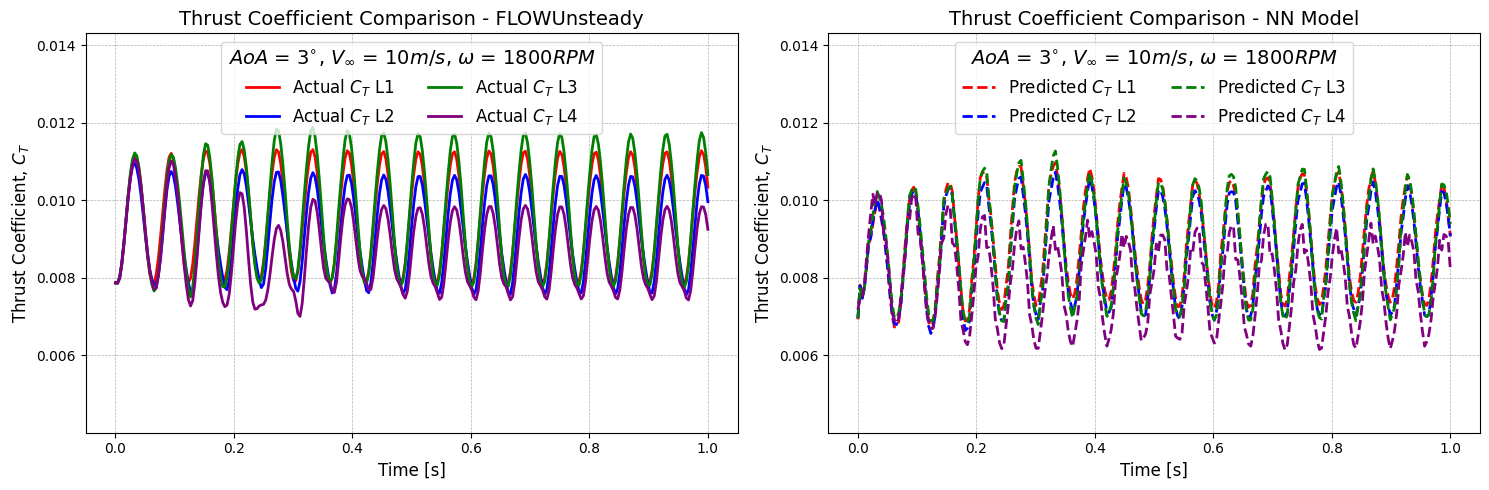

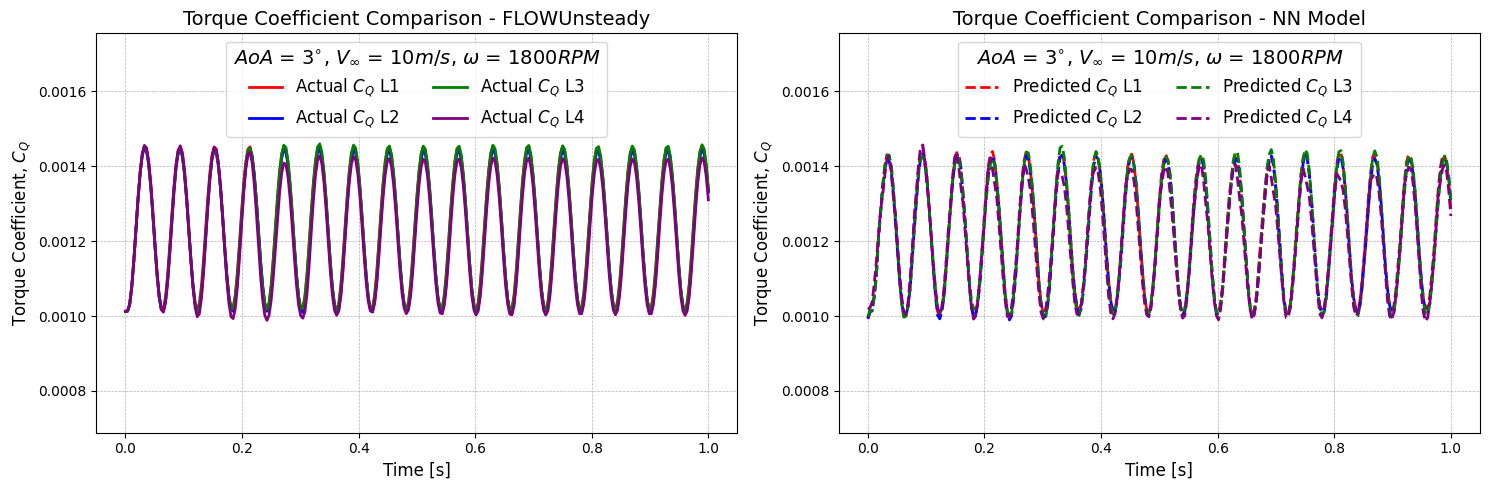

Simulation Case: eMO_hover_v10_r2200_a3
MAPE R1 CT: 1.4295237363687234 MAPE R1 CQ: 1.6381730879113907 epsilon R1 CT: 1.777722163622642 epsilon R1 CQ: 1.9551692120012227 R2 R1 CT: 0.9628316041548374 R2 R1 CQ: 0.9537465961205508
MAPE R2 CT: 1.4452863644835012 MAPE R2 CQ: 1.8147314052927257 epsilon R2 CT: 1.7687193124540281 epsilon R2 CQ: 2.1875783884534123 R2 R2 CT: 0.9588831351117242 R2 R2 CQ: 0.9422907410674985
MAPE R3 CT: 2.700775891582919 MAPE R3 CQ: 1.6301531181412403 epsilon R3 CT: 3.346320400345567 epsilon R3 CQ: 2.021915252044992 R2 R3 CT: 0.9056843852221685 R2 R3 CQ: 0.9522809877951898
MAPE R4 CT: 2.5128575260923975 MAPE R4 CQ: 1.665165844574501 epsilon R4 CT: 3.0529368096087803 epsilon R4 CQ: 2.1070081369684286 R2 R4 CT: 0.886334156829022 R2 R4 CQ: 0.9474423431643835
MAPE L1 CT: 1.4294681058988232 MAPE L1 CQ: 1.6376653942929826 epsilon L1 CT: 1.7769922809345247 epsilon L1 CQ: 1.9547476529697978 R2 L1 CT: 0.962863535062388 R2 L1 CQ: 0.9537670057092722
MAPE L2 CT: 1.4465948923759

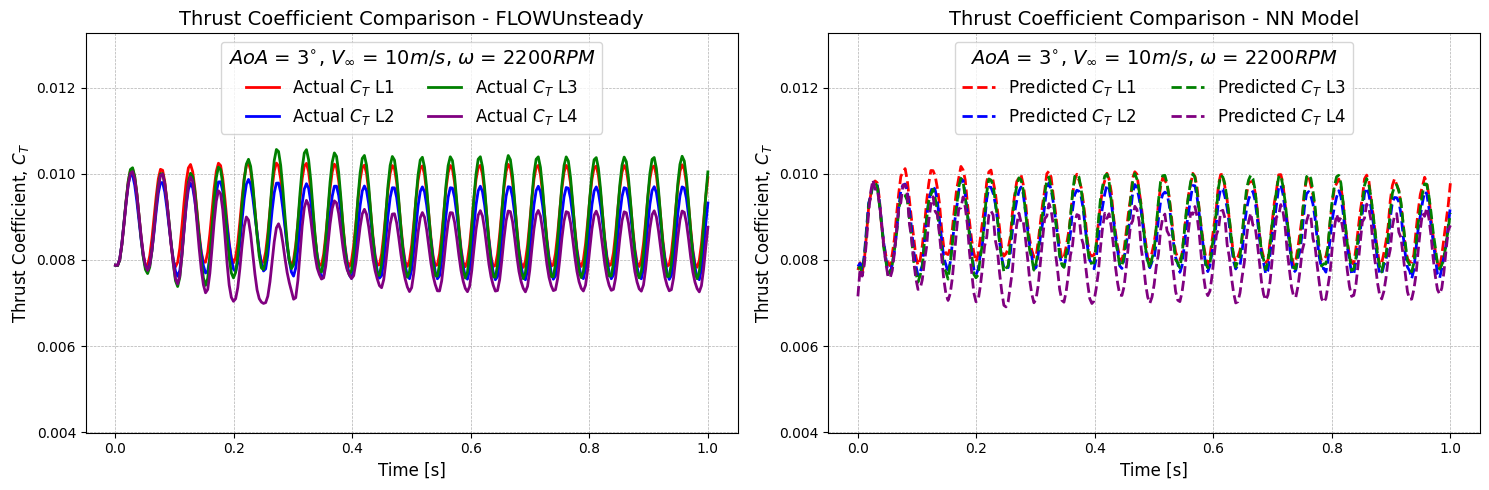

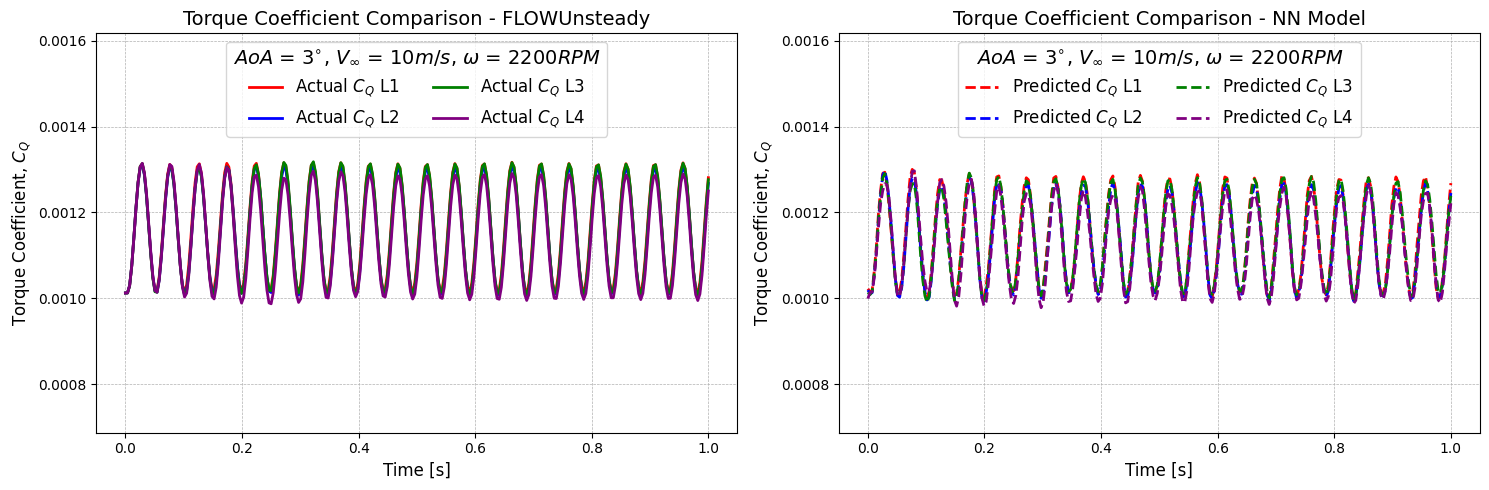

Simulation Case: eMO_hover_v12_r1600_a1
MAPE R1 CT: 24.656748125141547 MAPE R1 CQ: 18.558905217008753 epsilon R1 CT: 29.47736214874068 epsilon R1 CQ: 22.713243868986748 R2 R1 CT: -0.4721318646503503 R2 R1 CQ: -0.4115746261456239
MAPE R2 CT: 25.37814177719242 MAPE R2 CQ: 19.06661533060463 epsilon R2 CT: 29.4261404718009 epsilon R2 CQ: 23.407292670429943 R2 R2 CT: -0.47252306114033193 R2 R2 CQ: -0.474357175283737
MAPE R3 CT: 26.551851717402524 MAPE R3 CQ: 18.847245522426256 epsilon R3 CT: 32.969159107675175 epsilon R3 CQ: 23.659631920117548 R2 R3 CT: -0.5115834435701285 R2 R3 CQ: -0.47368867775151546
MAPE R4 CT: 33.597149825520106 MAPE R4 CQ: 24.155379241067845 epsilon R4 CT: 39.506880452688335 epsilon R4 CQ: 28.057637478241848 R2 R4 CT: -1.3814579500774515 R2 R4 CQ: -1.0647221794521906
MAPE L1 CT: 24.657156568089476 MAPE L1 CQ: 18.55898539642733 epsilon L1 CT: 29.477209690382512 epsilon L1 CQ: 22.713252658595913 R2 L1 CT: -0.4720411395459534 R2 L1 CQ: -0.4115583394043718
MAPE L2 CT: 25.

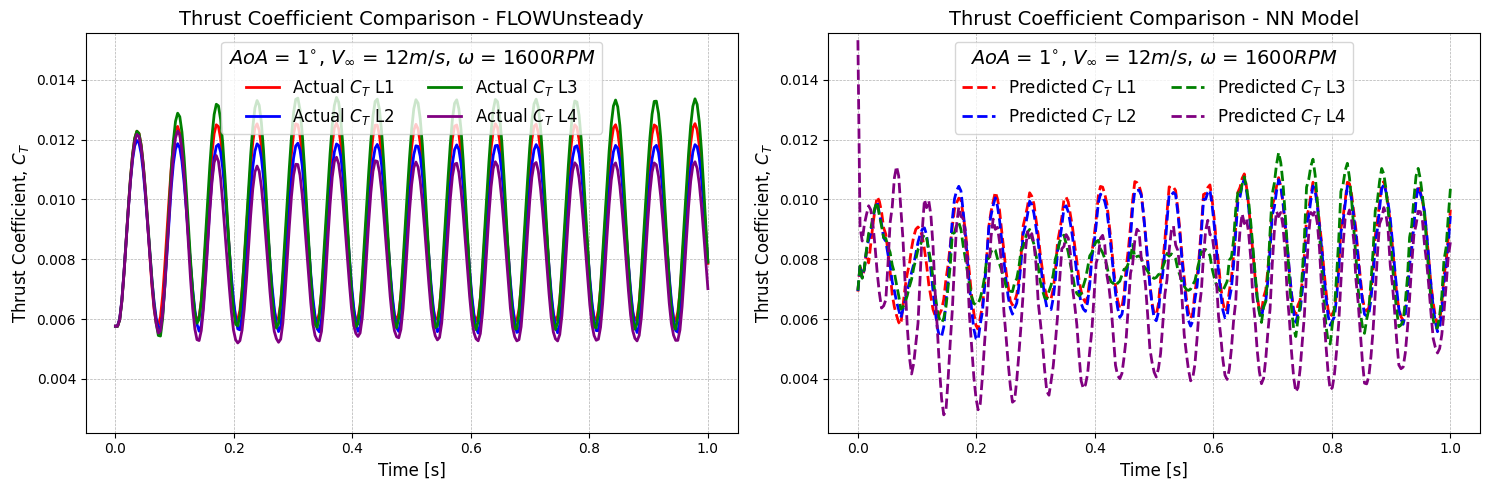

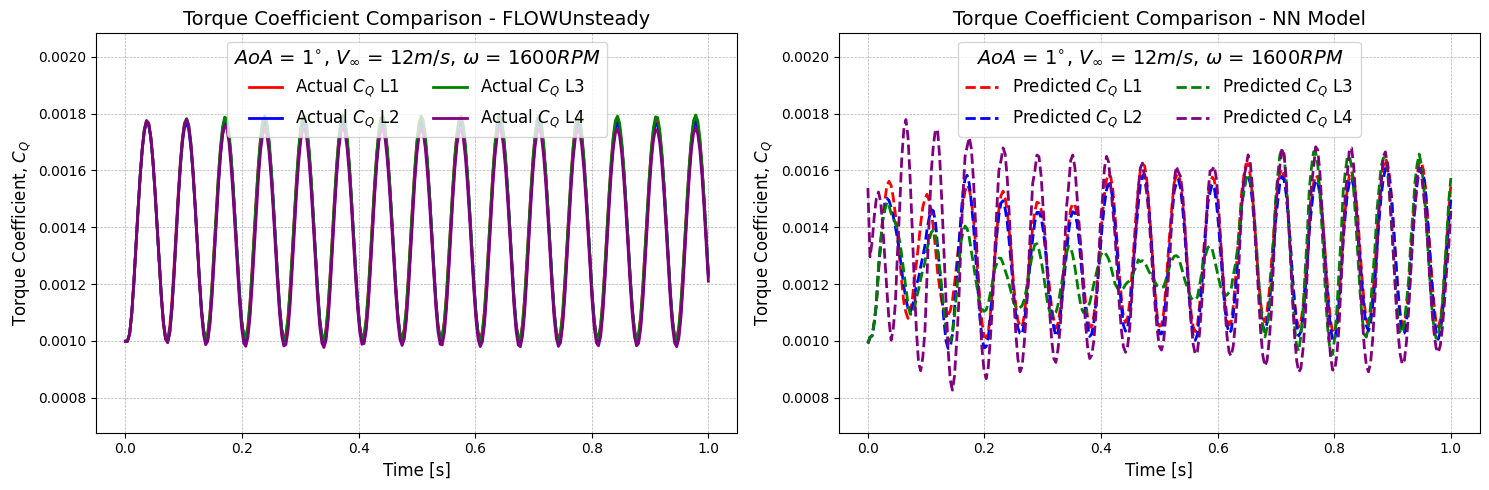

Simulation Case: eMO_hover_v12_r2000_a1
MAPE R1 CT: 11.973965891498112 MAPE R1 CQ: 1.5070292309747535 epsilon R1 CT: 11.724907026490394 epsilon R1 CQ: 1.709672421146071 R2 R1 CT: 0.48792731458512983 R2 R1 CQ: 0.9856579980683257
MAPE R2 CT: 15.259526767083775 MAPE R2 CQ: 2.056770524242948 epsilon R2 CT: 14.76129306048169 epsilon R2 CQ: 2.26838498325886 R2 R2 CT: 0.16575683963636034 R2 R2 CQ: 0.9750929456099733
MAPE R3 CT: 17.8661277546637 MAPE R3 CQ: 2.4383555572322515 epsilon R3 CT: 17.192138735668536 epsilon R3 CQ: 2.7088918787151166 R2 R3 CT: 0.11883029191363081 R2 R3 CQ: 0.9651391138036131
MAPE R4 CT: 17.458178216406495 MAPE R4 CQ: 3.2288359593899267 epsilon R4 CT: 16.803758455375075 epsilon R4 CQ: 3.523140771218647 R2 R4 CT: 0.03721537113406759 R2 R4 CQ: 0.9413664353714846
MAPE L1 CT: 11.97813219443903 MAPE L1 CQ: 1.507553848337015 epsilon L1 CT: 11.728920798409504 epsilon L1 CQ: 1.7101932430760907 R2 L1 CT: 0.48759485356703813 R2 L1 CQ: 0.9856494170790272
MAPE L2 CT: 15.2658384479

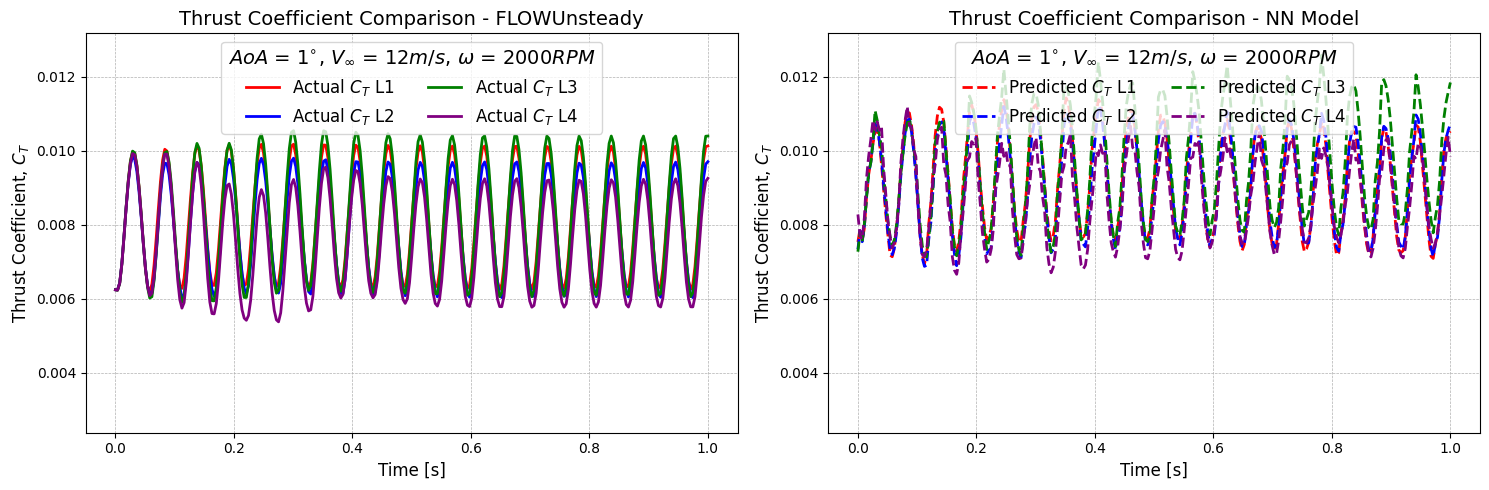

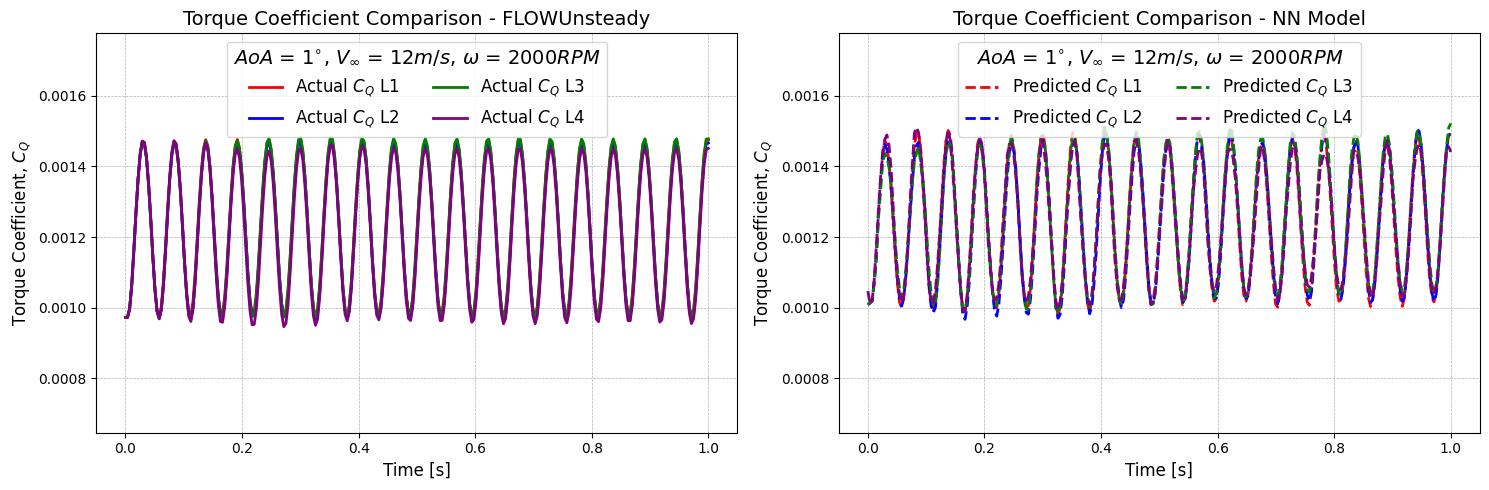

Simulation Case: eMO_hover_v5_r1800_a1
MAPE R1 CT: 3.2112472654494963 MAPE R1 CQ: 0.7343647995029643 epsilon R1 CT: 3.51880606871272 epsilon R1 CQ: 0.8813417867717918 R2 R1 CT: 0.41481165037747236 R2 R1 CQ: 0.9465669864209187
MAPE R2 CT: 4.1993948725908306 MAPE R2 CQ: 0.6918754442337501 epsilon R2 CT: 4.685978353276209 epsilon R2 CQ: 0.8399592971926008 R2 R2 CT: 0.5122507982180979 R2 R2 CQ: 0.9598146602481828
MAPE R3 CT: 6.237478687569349 MAPE R3 CQ: 0.6510582111489012 epsilon R3 CT: 6.816763827125594 epsilon R3 CQ: 0.7819992008487282 R2 R3 CT: 0.6180384195242523 R2 R3 CQ: 0.9696350685275313
MAPE R4 CT: 9.43750297903527 MAPE R4 CQ: 0.990880851036649 epsilon R4 CT: 9.69774519768774 epsilon R4 CQ: 1.256472120226034 R2 R4 CT: 0.7648990140421466 R2 R4 CQ: 0.9552252182224755
MAPE L1 CT: 3.219180562462335 MAPE L1 CQ: 0.7332394805079429 epsilon L1 CT: 3.5263691089929226 epsilon L1 CQ: 0.8803687905374171 R2 L1 CT: 0.41233222294664373 R2 L1 CQ: 0.9466870627515638
MAPE L2 CT: 4.205006125264863 M

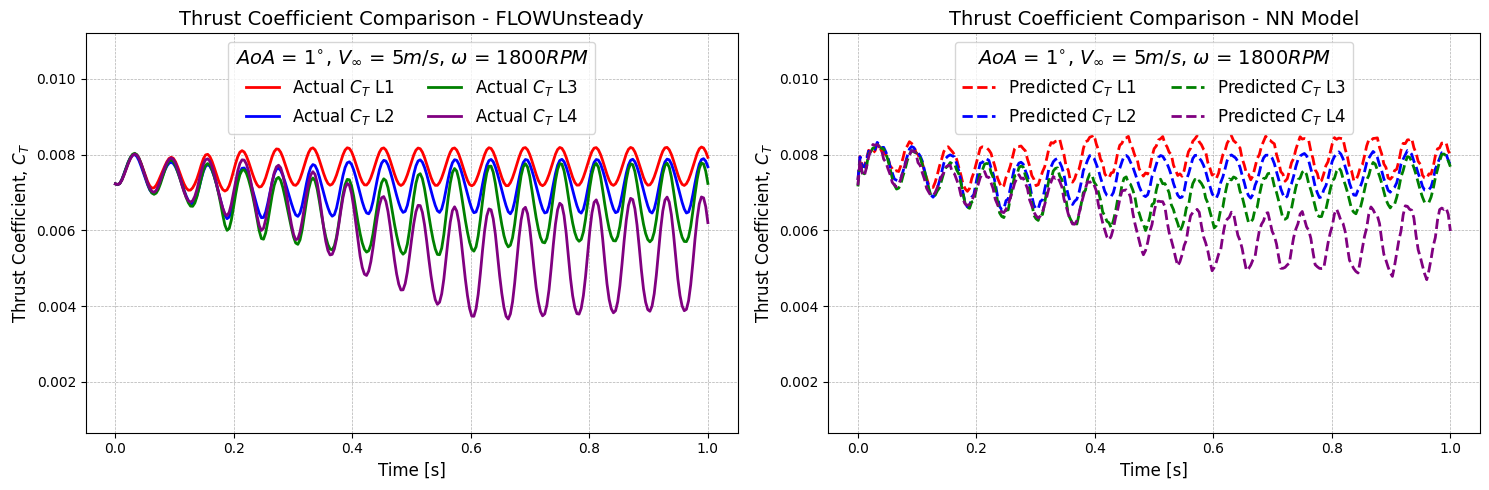

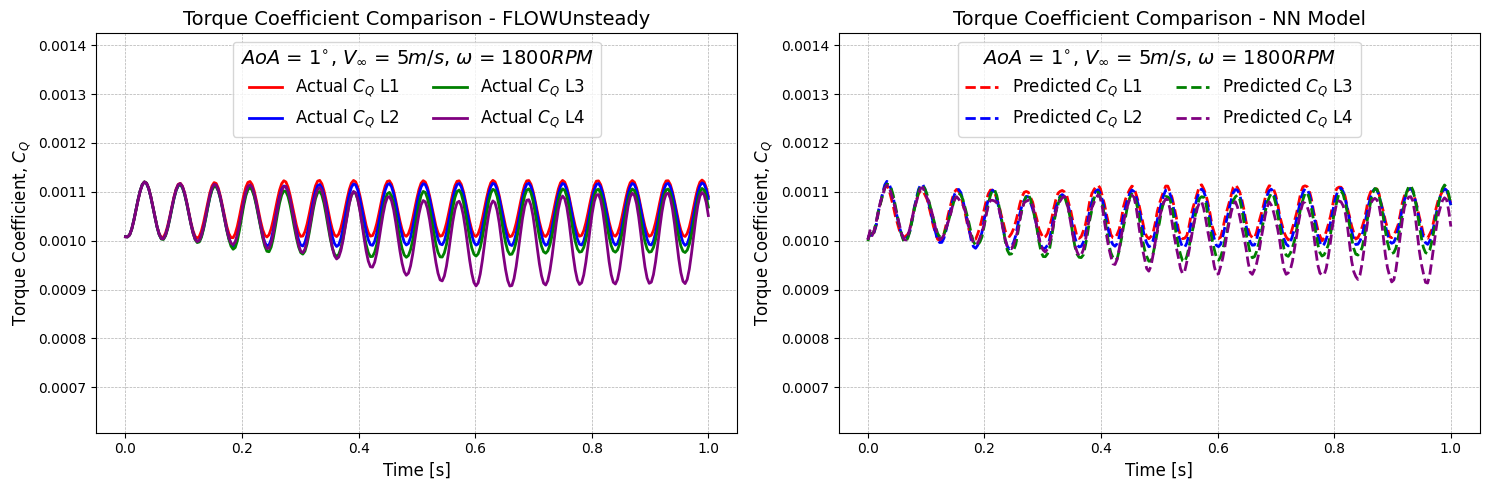

Simulation Case: eMO_hover_v8_r1800_a1
MAPE R1 CT: 8.07702747576779 MAPE R1 CQ: 1.4679654716215673 epsilon R1 CT: 8.284390826601257 epsilon R1 CQ: 1.596958512544496 R2 R1 CT: 0.3209389275254648 R2 R1 CQ: 0.9685758504136437
MAPE R2 CT: 8.5533978484615 MAPE R2 CQ: 1.3831714192411577 epsilon R2 CT: 8.915269115569615 epsilon R2 CQ: 1.5545941651657342 R2 R2 CT: 0.2950701646438477 R2 R2 CQ: 0.9716383962203633
MAPE R3 CT: 10.527487325921486 MAPE R3 CQ: 1.992496199414547 epsilon R3 CT: 10.319505823109267 epsilon R3 CQ: 2.0711669852316392 R2 R3 CT: 0.372006649289497 R2 R3 CQ: 0.950733901911649
MAPE R4 CT: 10.476246366190125 MAPE R4 CQ: 2.4726016792763086 epsilon R4 CT: 10.752614168819132 epsilon R4 CQ: 2.845342883126173 R2 R4 CT: 0.4788021438333696 R2 R4 CQ: 0.9178606424140855
MAPE L1 CT: 8.081379200730442 MAPE L1 CQ: 1.468711097804305 epsilon L1 CT: 8.288457780786398 epsilon L1 CQ: 1.5976532868137403 R2 L1 CT: 0.3203817543902965 R2 L1 CQ: 0.9685496239776299
MAPE L2 CT: 8.56305459111504 MAPE L2

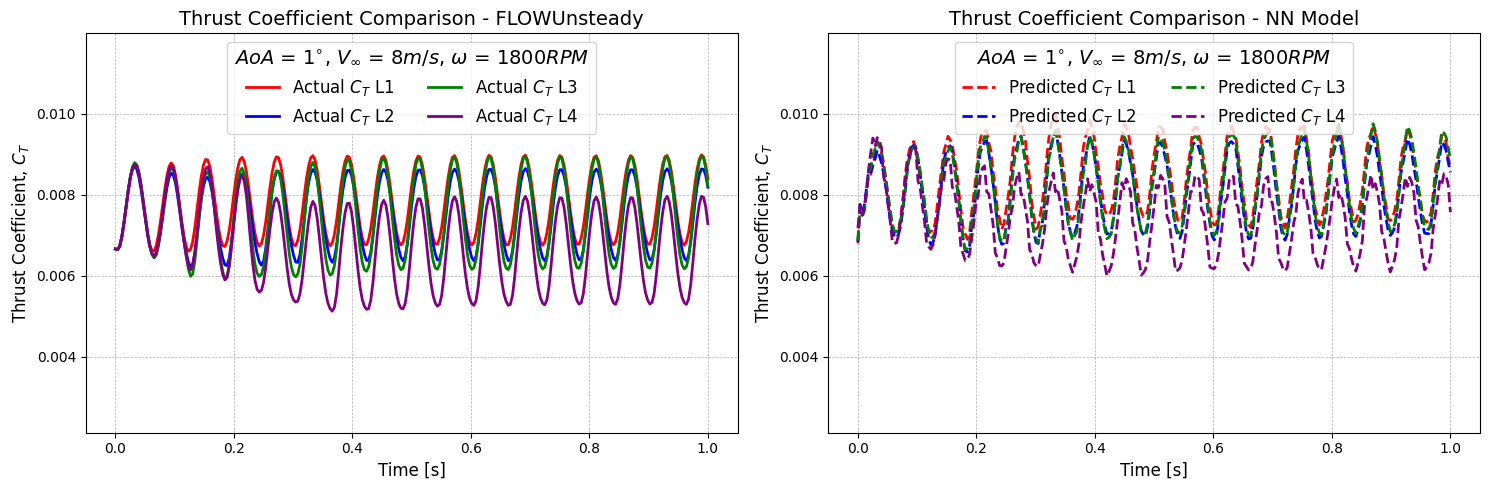

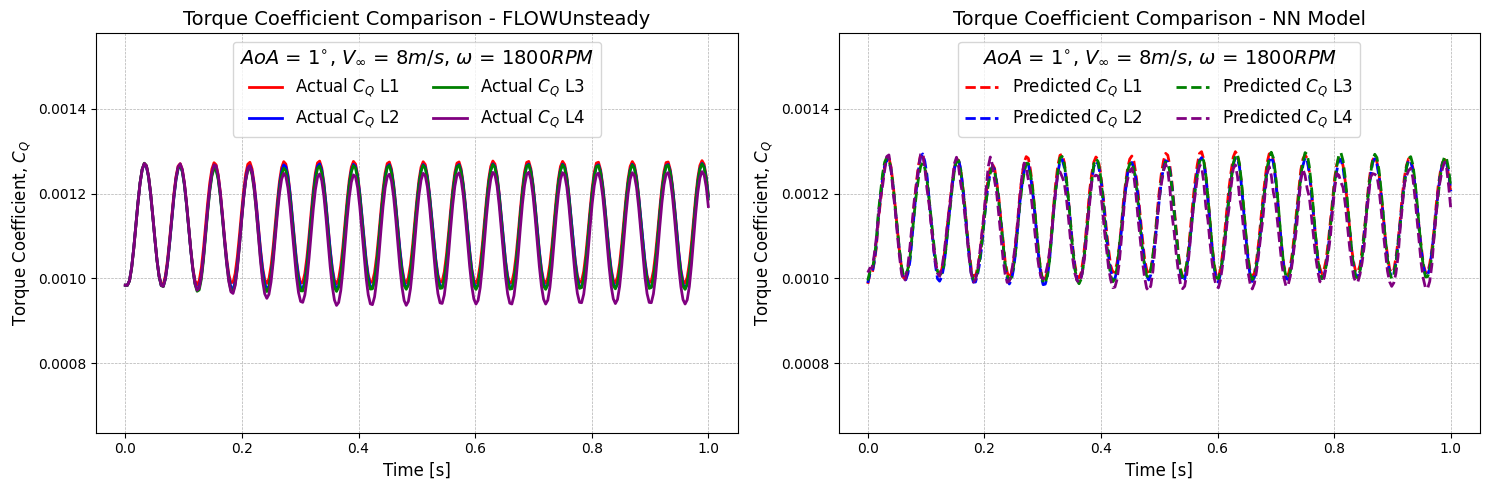

Simulation Case: eMO_hover_v8_r2000_a1
MAPE R1 CT: 8.858762444748207 MAPE R1 CQ: 0.5562104918784514 epsilon R1 CT: 8.903785634072651 epsilon R1 CQ: 0.6895517426062341 R2 R1 CT: -0.1182146531104924 R2 R1 CQ: 0.991572304577109
MAPE R2 CT: 8.699609066306909 MAPE R2 CQ: 0.7367358645310669 epsilon R2 CT: 8.767342499866102 epsilon R2 CQ: 0.8566862218206729 R2 R2 CT: 0.0476929991948718 R2 R2 CQ: 0.9876728493637892
MAPE R3 CT: 9.768978144660126 MAPE R3 CQ: 0.7724800317098951 epsilon R3 CT: 9.64633920574683 epsilon R3 CQ: 0.8870558988117091 R2 R3 CT: 0.2760321536534699 R2 R3 CQ: 0.9872683233903511
MAPE R4 CT: 11.131069548477363 MAPE R4 CQ: 1.2584113184824235 epsilon R4 CT: 11.165771646797383 epsilon R4 CQ: 1.4523749750107156 R2 R4 CT: 0.35856159437195545 R2 R4 CQ: 0.9708867488456028
MAPE L1 CT: 8.863720408278583 MAPE L1 CQ: 0.5564505861856031 epsilon L1 CT: 8.908563182497813 epsilon L1 CQ: 0.6897243405204705 R2 L1 CT: -0.11922553183333418 R2 L1 CQ: 0.9915684325074193
MAPE L2 CT: 8.7116651980354

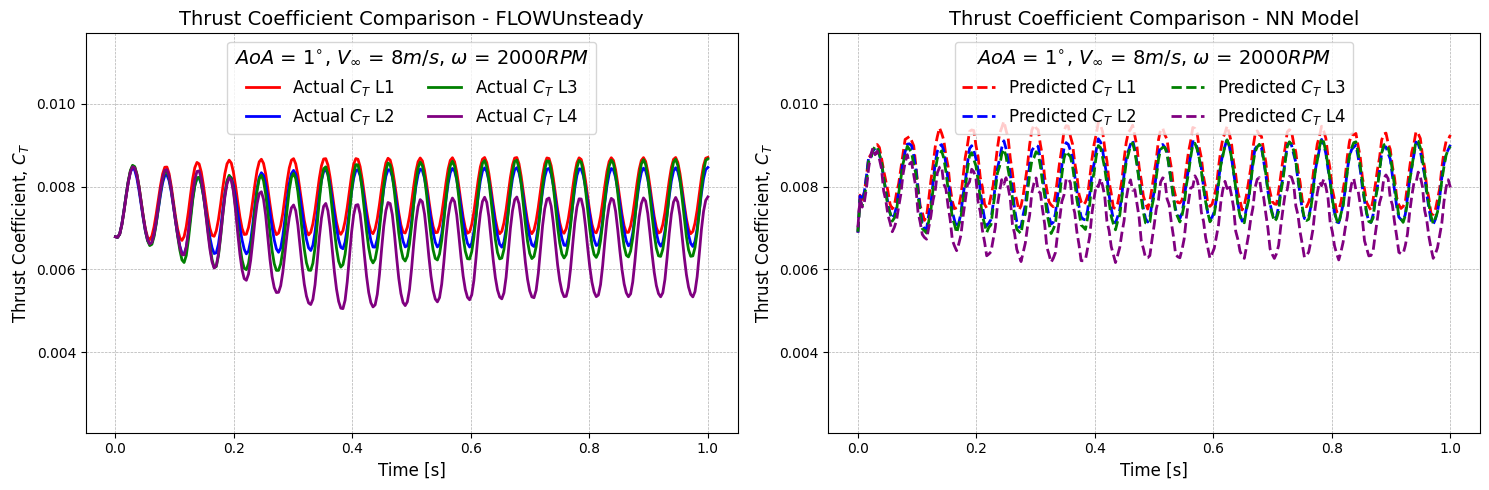

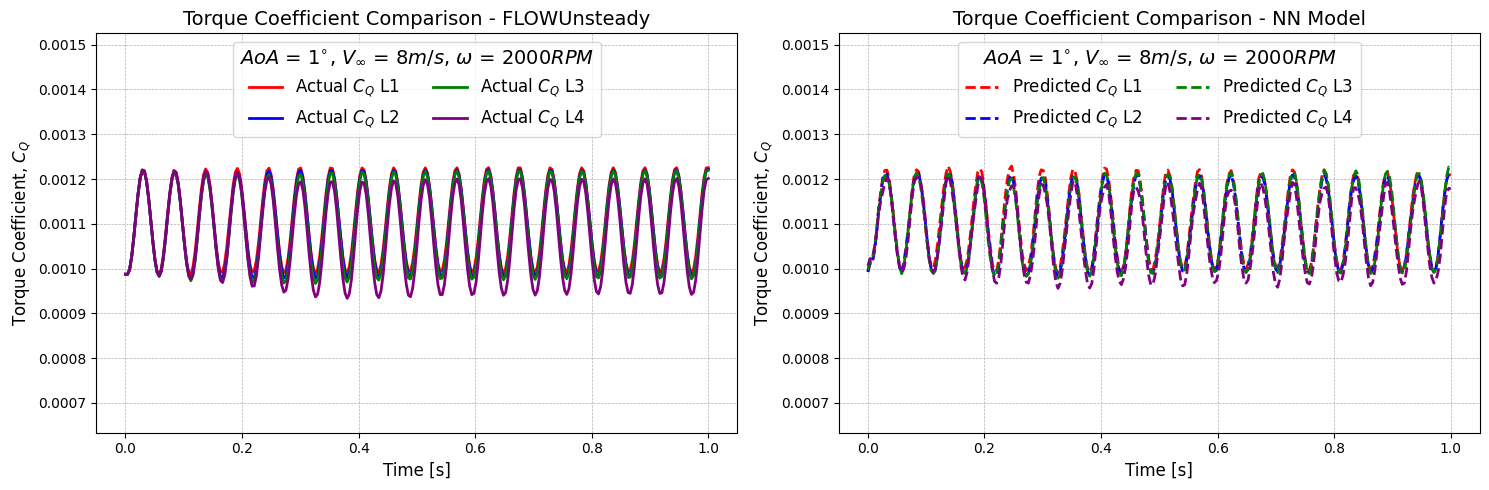

Simulation Case: eMO_hover_v9_r2000_a3
MAPE R1 CT: 4.047840038559849 MAPE R1 CQ: 1.7983839416970175 epsilon R1 CT: 4.15116510216647 epsilon R1 CQ: 1.94808910868033 R2 R1 CT: 0.789781057601177 R2 R1 CQ: 0.9529617624801537
MAPE R2 CT: 3.769284196271954 MAPE R2 CQ: 1.9245689111247375 epsilon R2 CT: 4.360699249986297 epsilon R2 CQ: 2.104756235011168 R2 R2 CT: 0.748587688591934 R2 R2 CQ: 0.9456067633897702
MAPE R3 CT: 6.363803892670802 MAPE R3 CQ: 1.9897850700444142 epsilon R3 CT: 6.687630061586727 epsilon R3 CQ: 2.238793946756204 R2 R3 CT: 0.6201757139009573 R2 R3 CQ: 0.9401753994272387
MAPE R4 CT: 8.065991814969674 MAPE R4 CQ: 2.3995550145567193 epsilon R4 CT: 8.690619066440119 epsilon R4 CQ: 2.737577532675171 R2 R4 CT: 0.1297284320703851 R2 R4 CQ: 0.9101879612118614
MAPE L1 CT: 4.044358572679214 MAPE L1 CQ: 1.7977397926343075 epsilon L1 CT: 4.147894696068161 epsilon L1 CQ: 1.947514631073632 R2 L1 CT: 0.7901281322675759 R2 L1 CQ: 0.9529904099870148
MAPE L2 CT: 3.761059865140103 MAPE L2 CQ

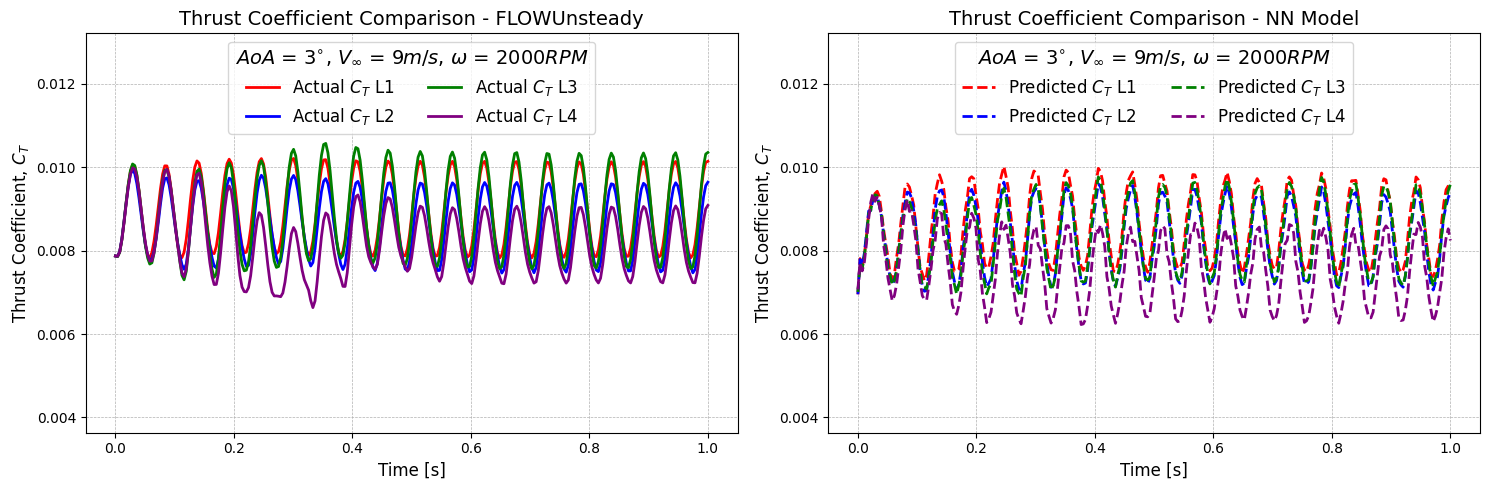

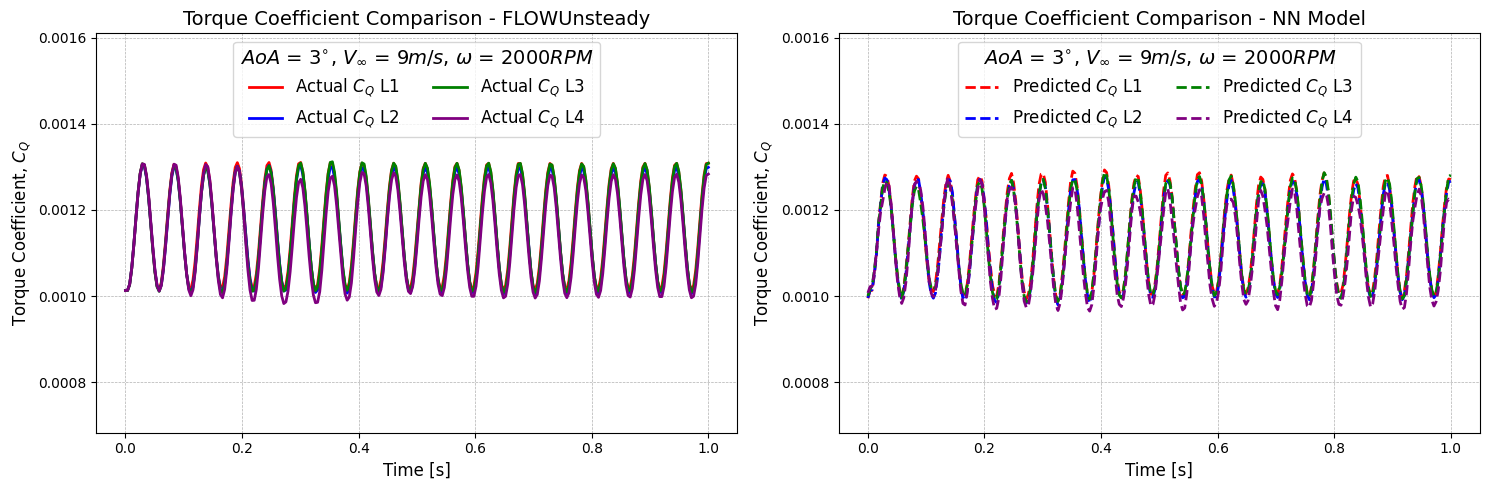

################################################################################################################
Average MAPE Rotor L1 CT: 8.660042367726966 Average MAPE Rotor L1 CQ: 3.4586765138760134 Average MAPE Rotor L1: 6.05935944080149
Average MAPE Rotor L2 CT: 9.136454011145352 Average MAPE Rotor L2 CQ: 3.631424656742798 Average MAPE Rotor L2: 6.383939333944075
Average MAPE Rotor L3 CT: 11.173979225318877 Average MAPE Rotor L3 CQ: 3.7314647588545764 Average MAPE Rotor L3: 7.452721992086728
Average MAPE Rotor L4 CT: 12.749699191019863 Average MAPE Rotor L4 CQ: 4.7739147782882325 Average MAPE Rotor L4: 8.761806984654047
Average MAPE Rotor R1 CT: 8.661842825529876 Average MAPE Rotor R1 CQ: 3.4585157230878325 Average MAPE Rotor R1: 6.0601792743088545
Average MAPE Rotor R2 CT: 9.139390291245075 Average MAPE Rotor R2 CQ: 3.631240320888259 Average MAPE Rotor R2: 6.385315306066667
Average MAPE Rotor R3 CT: 11.177804765461184 Average MAPE Rotor R3 CQ: 3.730564228090013 Average MAPE Rotor

In [33]:
from sklearn.metrics import mean_squared_error, r2_score


def mape(y_true, y_pred):
    """Compute Mean Absolute Percentage Error (MAPE)"""
    mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def relative_l2_norm(y_true, y_pred):
    """Compute Relative L2 Norm Error (ε)"""
    mask = y_true != 0  # Avoid division by zero
    numerator = np.linalg.norm(y_pred[mask] - y_true[mask], ord=2)  # ||pred - true||_2
    denominator = np.linalg.norm(y_true[mask], ord=2)  # ||true||_2
    return (numerator / denominator) * 100

# Initialize lists to store evaluation results
mape_r1_ct_list, mape_r1_cq_list = [], []
mape_r2_ct_list, mape_r2_cq_list = [], []
mape_r3_ct_list, mape_r3_cq_list = [], []
mape_r4_ct_list, mape_r4_cq_list = [], []
mape_l1_ct_list, mape_l1_cq_list = [], []
mape_l2_ct_list, mape_l2_cq_list = [], []
mape_l3_ct_list, mape_l3_cq_list = [], []
mape_l4_ct_list, mape_l4_cq_list = [], []

mape_r1_list = []
mape_r2_list = []
mape_r3_list = []
mape_r4_list = []
mape_l1_list = []
mape_l2_list = []
mape_l3_list = []
mape_l4_list = []


epsilon_r1_ct_list, epsilon_r1_cq_list = [], []
epsilon_r2_ct_list, epsilon_r2_cq_list = [], []
epsilon_r3_ct_list, epsilon_r3_cq_list = [], []
epsilon_r4_ct_list, epsilon_r4_cq_list = [], []
epsilon_l1_ct_list, epsilon_l1_cq_list = [], []
epsilon_l2_ct_list, epsilon_l2_cq_list = [], []
epsilon_l3_ct_list, epsilon_l3_cq_list = [], []
epsilon_l4_ct_list, epsilon_l4_cq_list = [], []

epsilon_r1_list = []
epsilon_r2_list = []
epsilon_r3_list = []
epsilon_r4_list = []
epsilon_l1_list = []
epsilon_l2_list = []
epsilon_l3_list = []
epsilon_l4_list = []


mape_r1_ct_list, mape_r1_cq_list = [], []
mape_r2_ct_list, mape_r2_cq_list = [], []
mape_r3_ct_list, mape_r3_cq_list = [], []
mape_r4_ct_list, mape_r4_cq_list = [], []
mape_l1_ct_list, mape_l1_cq_list = [], []
mape_l2_ct_list, mape_l2_cq_list = [], []
mape_l3_ct_list, mape_l3_cq_list = [], []
mape_l4_ct_list, mape_l4_cq_list = [], []

mape_r1_list = []
mape_r2_list = []
mape_r3_list = []
mape_r4_list = []
mape_l1_list = []
mape_l2_list = []
mape_l3_list = []
mape_l4_list = []


r2_r1_ct_list, r2_r1_cq_list = [], []
r2_r2_ct_list, r2_r2_cq_list = [], []
r2_r3_ct_list, r2_r3_cq_list = [], []
r2_r4_ct_list, r2_r4_cq_list = [], []
r2_l1_ct_list, r2_l1_cq_list = [], []
r2_l2_ct_list, r2_l2_cq_list = [], []
r2_l3_ct_list, r2_l3_cq_list = [], []
r2_l4_ct_list, r2_l4_cq_list = [], []

r2_r1_list = []
r2_r2_list = []
r2_r3_list = []
r2_r4_list = []
r2_l1_list = []
r2_l2_list = []
r2_l3_list = []
r2_l4_list = []

simulation_case_list = []

root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/testing_data/'
batch_size_test = 1

for simulation_case in os.listdir(root_test_base):

    root_test_dir = root_test_base+simulation_case

    # Canard dataset
    dataset_canard_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_canard_test, outputs_canard_test = dataset_canard_test[0:]

    input_tensor_canard_test = inputs_canard_test
    input_tensor_canard_test = inputs_canard_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_canard_test = outputs_canard_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape)

    dataset_wing_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)
    
    inputs_wing_test, outputs_wing_test = dataset_wing_test[0:]

    input_tensor_wing_test = inputs_wing_test
    input_tensor_wing_test = inputs_wing_test.squeeze(1)  # Reshaping
    # print("Input shape (Wing dataset):", input_tensor_wing.shape)
    output_tensor_wing_test = outputs_wing_test.squeeze(1)
    # print("Output shape (Wing dataset):",output_tensor_wing.shape)


    # dataset - Rotor L1
    dataset_rotor_L1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL1_test, outputs_rL1_test = dataset_rotor_L1_test[0:]

    input_tensor_rL1_test = inputs_rL1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - L1):", input_tensor_rL1.shape) 
    output_tensor_rL1_test = outputs_rL1_test.squeeze(1)
    # print("Output shape (rotor - L1):",output_tensor_rL1.shape)

    dataset_rotor_L2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL2_test, outputs_rL2_test = dataset_rotor_L2_test[0:]

    input_tensor_rL2_test = inputs_rL2_test.squeeze(1)  # Reshaping
    output_tensor_rL2_test = outputs_rL2_test.squeeze(1)

    dataset_rotor_L3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL3_test, outputs_rL3_test = dataset_rotor_L3_test[0:]

    input_tensor_rL3_test = inputs_rL3_test.squeeze(1)  # Reshaping
    output_tensor_rL3_test = outputs_rL3_test.squeeze(1)

    dataset_rotor_L4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'L4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rL4_test, outputs_rL4_test = dataset_rotor_L4_test[0:]

    input_tensor_rL4_test = inputs_rL4_test.squeeze(1)  # Reshaping
    output_tensor_rL4_test = outputs_rL4_test.squeeze(1)

    # dataset - Rotor R1
    dataset_rotor_R1_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R1',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR1_test, outputs_rR1_test = dataset_rotor_R1_test[0:]

    input_tensor_rR1_test = inputs_rR1_test.squeeze(1)  # Reshaping
    # print("Input shape (rotor - R1):", input_tensor_rR1.shape) 
    output_tensor_rR1_test = outputs_rR1_test.squeeze(1)
    # print("Output shape (rotor - R1):",output_tensor_rR1.shape) 

    dataset_rotor_R2_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R2',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR2_test, outputs_rR2_test = dataset_rotor_R2_test[0:]

    input_tensor_rR2_test = inputs_rR2_test.squeeze(1)  # Reshaping
    output_tensor_rR2_test = outputs_rR2_test.squeeze(1)

    dataset_rotor_R3_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R3',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR3_test, outputs_rR3_test = dataset_rotor_R3_test[0:]

    input_tensor_rR3_test = inputs_rR3_test.squeeze(1)  # Reshaping
    output_tensor_rR3_test = outputs_rR3_test.squeeze(1)

    dataset_rotor_R4_test = PropellerDataset(root_test_dir,
                            rotor_notation = 'R4',                       # Select: L1, L2, L3, L4, R1, R2, R3, R4
                            subdir_condition=subdir_condition_rotor)
    inputs_rR4_test, outputs_rR4_test = dataset_rotor_R4_test[0:]
    
    input_tensor_rR4_test = inputs_rR4_test.squeeze(1)  # Reshaping
    output_tensor_rR4_test = outputs_rR4_test.squeeze(1)

    dataset_aircraft_test = AircraftDataset(dataset_wing_test,
                                            dataset_canard_test,
                                            dataset_rotor_L1_test,
                                            dataset_rotor_L2_test,
                                            dataset_rotor_L3_test,
                                            dataset_rotor_L4_test,
                                            dataset_rotor_R1_test,
                                            dataset_rotor_R2_test,
                                            dataset_rotor_R3_test,
                                            dataset_rotor_R4_test,
                                            input_scaler_wing_temp, output_scaler_wing_temp,
                                            input_scaler_rotor1, output_scaler_rotor1,
                                            input_scaler_rotor2, output_scaler_rotor2,
                                            input_scaler_rotor3, output_scaler_rotor3,
                                            input_scaler_rotor4, output_scaler_rotor4)


    graph_dataset_test = GraphDataset(dataset_aircraft_test)

    graph_dataset_test = graph_dataset_test[0]

    node_inputs_test = (graph_dataset_test.x).to(device)
    edge_index_test = (graph_dataset_test.edge_index).to(device)
    edge_attr_test = (graph_dataset_test.edge_attr).to(device)
    global_inputs_test = (graph_dataset_test.global_input).to(device)
    targets_test = (graph_dataset_test.y).to(device)
    

    # composite_model.eval()  # Set the model to evaluation mode


    with torch.no_grad():
        outputs_predicted = scripted_model(node_inputs_test, targets_test, edge_index_test,
                                             edge_attr_test, global_inputs_test,
                                             batch_size_test, num_nodes=4)

    
    
    outputs_predicted = outputs_predicted.cpu().detach().numpy()  # Convert tensor to numpy array
    outputs_predicted = outputs_predicted.squeeze(0)

    # predicted_outputs_wing = outputs_predicted[:, 0:2]
    # predicted_outputs_canard = outputs_predicted[:, 2:4]
    predicted_outputs_rotor_L1 = outputs_predicted[:, 0:2]
    # predicted_outputs_rotor_R1 = outputs_predicted[:, 6:8]
    predicted_outputs_rotor_L2 = outputs_predicted[:, 2:4]
    # predicted_outputs_rotor_R2 = outputs_predicted[:, 10:12]
    predicted_outputs_rotor_L3 = outputs_predicted[:, 4:6]
    # predicted_outputs_rotor_R3 = outputs_predicted[:, 14:16]
    predicted_outputs_rotor_L4 = outputs_predicted[:, 6:]
    # predicted_outputs_rotor_R4 = outputs_predicted[:, 18:20]
    
    # predicted_outputs_wing_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_wing)
    # predicted_outputs_canard_og_scl = output_scaler_wing_stat.inverse_transform(predicted_outputs_canard)
    predicted_outputs_rotor_L1_og_scl = output_scaler_rotor1.inverse_transform(predicted_outputs_rotor_L1)
    # predicted_outputs_rotor_R1_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R1)
    predicted_outputs_rotor_L2_og_scl = output_scaler_rotor2.inverse_transform(predicted_outputs_rotor_L2)
    # predicted_outputs_rotor_R2_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R2)
    predicted_outputs_rotor_L3_og_scl = output_scaler_rotor3.inverse_transform(predicted_outputs_rotor_L3)
    # predicted_outputs_rotor_R3_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R3)
    predicted_outputs_rotor_L4_og_scl = output_scaler_rotor4.inverse_transform(predicted_outputs_rotor_L4)
    # predicted_outputs_rotor_R4_og_scl = output_scaler_rotor.inverse_transform(predicted_outputs_rotor_R4)

    # time_steps = time_steps.cpu().detach().numpy()
    time_steps = (global_inputs_test.squeeze(0))[:,0]
    time_steps = time_steps.cpu().detach().numpy()

    # Predictions from the Neural Network
    # cl_test_NN_wing = predicted_outputs_wing_og_scl[:, 0]
    # cd_test_NN_wing = predicted_outputs_wing_og_scl[:, 1]

    # cl_test_NN_canard = predicted_outputs_canard_og_scl[:, 0]
    # cd_test_NN_canard = predicted_outputs_canard_og_scl[:, 1]

    ct_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 0]
    cq_test_NN_L1 = predicted_outputs_rotor_L1_og_scl[:, 1]

    ct_test_NN_R1 = ct_test_NN_L1
    cq_test_NN_R1 = cq_test_NN_L1

    # ct_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 0]
    # cq_test_NN_R1 = predicted_outputs_rotor_R1_og_scl[:, 1]
    
    ct_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 0]
    cq_test_NN_L2 = predicted_outputs_rotor_L2_og_scl[:, 1]

    ct_test_NN_R2 = ct_test_NN_L2
    cq_test_NN_R2 = cq_test_NN_L2


    # ct_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 0]
    # cq_test_NN_R2 = predicted_outputs_rotor_R2_og_scl[:, 1]

    ct_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 0]
    cq_test_NN_L3 = predicted_outputs_rotor_L3_og_scl[:, 1]

    ct_test_NN_R3 = ct_test_NN_L3
    cq_test_NN_R3 = cq_test_NN_L3


    # ct_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 0]
    # cq_test_NN_R3 = predicted_outputs_rotor_R3_og_scl[:, 1]

    ct_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 0]
    cq_test_NN_L4 = predicted_outputs_rotor_L4_og_scl[:, 1]

    ct_test_NN_R4 = ct_test_NN_L4
    cq_test_NN_R4 = cq_test_NN_L4


    # ct_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 0]
    # cq_test_NN_R4 = predicted_outputs_rotor_R4_og_scl[:, 1]

    
    # FLOWUnsteady dataset
    # cl_test_flowuns_canard = dataset_canard_test.get_variable('CL')
    # cd_test_flowuns_canard = dataset_canard_test.get_variable('CD')
    # cl_test_flowuns_wing = dataset_wing_test.get_variable('CL')
    # cd_test_flowuns_wing = dataset_wing_test.get_variable('CD')
    ct_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CT')
    cq_test_flowuns_L1 = dataset_rotor_L1_test.get_variable('CQ')
    ct_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CT')
    cq_test_flowuns_L2 = dataset_rotor_L2_test.get_variable('CQ')
    ct_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CT')
    cq_test_flowuns_L3 = dataset_rotor_L3_test.get_variable('CQ')
    ct_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CT')
    cq_test_flowuns_L4 = dataset_rotor_L4_test.get_variable('CQ')
    ct_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CT')
    cq_test_flowuns_R1 = dataset_rotor_R1_test.get_variable('CQ')
    ct_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CT')
    cq_test_flowuns_R2 = dataset_rotor_R2_test.get_variable('CQ')
    ct_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CT')
    cq_test_flowuns_R3 = dataset_rotor_R3_test.get_variable('CQ')
    ct_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CT')
    cq_test_flowuns_R4 = dataset_rotor_R4_test.get_variable('CQ')

    ct_test_flowuns_L1 = align_timesteps(ct_test_flowuns_L1[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L1 = align_timesteps(cq_test_flowuns_L1[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_L2 = align_timesteps(ct_test_flowuns_L2[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L2 = align_timesteps(cq_test_flowuns_L2[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_L3 = align_timesteps(ct_test_flowuns_L3[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L3 = align_timesteps(cq_test_flowuns_L3[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_L4 = align_timesteps(ct_test_flowuns_L4[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_L4 = align_timesteps(cq_test_flowuns_L4[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R1 = align_timesteps(ct_test_flowuns_R1[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R1 = align_timesteps(cq_test_flowuns_R1[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R2 = align_timesteps(ct_test_flowuns_R2[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R2 = align_timesteps(cq_test_flowuns_R2[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R3 = align_timesteps(ct_test_flowuns_R3[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R3 = align_timesteps(cq_test_flowuns_R3[0][np.newaxis, :], len(time_steps))
    ct_test_flowuns_R4 = align_timesteps(ct_test_flowuns_R4[0][np.newaxis, :], len(time_steps))
    cq_test_flowuns_R4 = align_timesteps(cq_test_flowuns_R4[0][np.newaxis, :], len(time_steps))


    model_outputs = {
        # "Cl_Wing": cl_test_NN_wing,
        # "Cd_Wing": cd_test_NN_wing,
        # "Cl_Canard": cl_test_NN_canard,
        # "Cd_Canard": cd_test_NN_canard,
        "Ct_L1": ct_test_NN_L1,
        "Cq_L1": cq_test_NN_L1,
        "Ct_L2": ct_test_NN_L2,
        "Cq_L2": cq_test_NN_L2,
        "Ct_L3": ct_test_NN_L3,
        "Cq_L3": cq_test_NN_L3,
        "Ct_L4": ct_test_NN_L4,
        "Cq_L4": cq_test_NN_L4,
        "Ct_R1": ct_test_NN_R1,
        "Cq_R1": cq_test_NN_R1,
        "Ct_R2": ct_test_NN_R2,
        "Cq_R2": cq_test_NN_R2,
        "Ct_R3": ct_test_NN_R3,
        "Cq_R3": cq_test_NN_R3,
        "Ct_R4": ct_test_NN_R4,
        "Cq_R4": cq_test_NN_R4,
    }

    ground_truths = {
        # "Cl_Wing": cl_test_flowuns_wing[0],
        # "Cd_Wing": cd_test_flowuns_wing[0],
        # "Cl_Canard": cl_test_flowuns_canard[0],
        # "Cd_Canard": cd_test_flowuns_canard[0],
        "Ct_L1": ct_test_flowuns_L1[0],
        "Cq_L1": cq_test_flowuns_L1[0],
        "Ct_L2": ct_test_flowuns_L2[0],
        "Cq_L2": cq_test_flowuns_L2[0],
        "Ct_L3": ct_test_flowuns_L3[0],
        "Cq_L3": cq_test_flowuns_L3[0], 
        "Ct_L4": ct_test_flowuns_L4[0],
        "Cq_L4": cq_test_flowuns_L4[0],
        "Ct_R1": ct_test_flowuns_R1[0],
        "Cq_R1": cq_test_flowuns_R1[0],
        "Ct_R2": ct_test_flowuns_R2[0],
        "Cq_R2": cq_test_flowuns_R2[0],
        "Ct_R3": ct_test_flowuns_R3[0],
        "Cq_R3": cq_test_flowuns_R3[0],
        "Ct_R4": ct_test_flowuns_R4[0],
        "Cq_R4": cq_test_flowuns_R4[0],
    }

    mape_l1_ct = mape(ground_truths["Ct_L1"], model_outputs["Ct_L1"])
    mape_l1_cq = mape(ground_truths["Cq_L1"], model_outputs["Cq_L1"])
    mape_l2_ct = mape(ground_truths["Ct_L2"], model_outputs["Ct_L2"])
    mape_l2_cq = mape(ground_truths["Cq_L2"], model_outputs["Cq_L2"])
    mape_l3_ct = mape(ground_truths["Ct_L3"], model_outputs["Ct_L3"])
    mape_l3_cq = mape(ground_truths["Cq_L3"], model_outputs["Cq_L3"])
    mape_l4_ct = mape(ground_truths["Ct_L4"], model_outputs["Ct_L4"])
    mape_l4_cq = mape(ground_truths["Cq_L4"], model_outputs["Cq_L4"])
    mape_r1_ct = mape(ground_truths["Ct_R1"], model_outputs["Ct_R1"])
    mape_r1_cq = mape(ground_truths["Cq_R1"], model_outputs["Cq_R1"])
    mape_r2_ct = mape(ground_truths["Ct_R2"], model_outputs["Ct_R2"])
    mape_r2_cq = mape(ground_truths["Cq_R2"], model_outputs["Cq_R2"])
    mape_r3_ct = mape(ground_truths["Ct_R3"], model_outputs["Ct_R3"])
    mape_r3_cq = mape(ground_truths["Cq_R3"], model_outputs["Cq_R3"])
    mape_r4_ct = mape(ground_truths["Ct_R4"], model_outputs["Ct_R4"])
    mape_r4_cq = mape(ground_truths["Cq_R4"], model_outputs["Cq_R4"])


    mape_l1_ct_list.append(mape_l1_ct)
    mape_l1_cq_list.append(mape_l1_cq)
    mape_l2_ct_list.append(mape_l2_ct)
    mape_l2_cq_list.append(mape_l2_cq)
    mape_l3_ct_list.append(mape_l3_ct)
    mape_l3_cq_list.append(mape_l3_cq)
    mape_l4_ct_list.append(mape_l4_ct)
    mape_l4_cq_list.append(mape_l4_cq)
    mape_r1_ct_list.append(mape_r1_ct)
    mape_r1_cq_list.append(mape_r1_cq)
    mape_r2_ct_list.append(mape_r2_ct)
    mape_r2_cq_list.append(mape_r2_cq)
    mape_r3_ct_list.append(mape_r3_ct)
    mape_r3_cq_list.append(mape_r3_cq)
    mape_r4_ct_list.append(mape_r4_ct)
    mape_r4_cq_list.append(mape_r4_cq)

    mape_l1 = (mape_l1_ct + mape_l1_cq) / 2
    mape_l2 = (mape_l2_ct + mape_l2_cq) / 2
    mape_l3 = (mape_l3_ct + mape_l3_cq) / 2
    mape_l4 = (mape_l4_ct + mape_l4_cq) / 2 
    mape_r1 = (mape_r1_ct + mape_r1_cq) / 2
    mape_r2 = (mape_r2_ct + mape_r2_cq) / 2
    mape_r3 = (mape_r3_ct + mape_r3_cq) / 2
    mape_r4 = (mape_r4_ct + mape_r4_cq) / 2

    mape_l1_list.append(mape_l1)
    mape_l2_list.append(mape_l2)
    mape_l3_list.append(mape_l3)
    mape_l4_list.append(mape_l4)
    mape_r1_list.append(mape_r1)
    mape_r2_list.append(mape_r2)
    mape_r3_list.append(mape_r3)
    mape_r4_list.append(mape_r4)

    # Calculate R2
    r2_r1_ct = r2_score(ground_truths["Ct_R1"], model_outputs["Ct_R1"])
    r2_r1_cq = r2_score(ground_truths["Cq_R1"], model_outputs["Cq_R1"])
    r2_r2_ct = r2_score(ground_truths["Ct_R2"], model_outputs["Ct_R2"])
    r2_r2_cq = r2_score(ground_truths["Cq_R2"], model_outputs["Cq_R2"])
    r2_r3_ct = r2_score(ground_truths["Ct_R3"], model_outputs["Ct_R3"])
    r2_r3_cq = r2_score(ground_truths["Cq_R3"], model_outputs["Cq_R3"])
    r2_r4_ct = r2_score(ground_truths["Ct_R4"], model_outputs["Ct_R4"])
    r2_r4_cq = r2_score(ground_truths["Cq_R4"], model_outputs["Cq_R4"])
    r2_l1_ct = r2_score(ground_truths["Ct_L1"], model_outputs["Ct_L1"])
    r2_l1_cq = r2_score(ground_truths["Cq_L1"], model_outputs["Cq_L1"])
    r2_l2_ct = r2_score(ground_truths["Ct_L2"], model_outputs["Ct_L2"])
    r2_l2_cq = r2_score(ground_truths["Cq_L2"], model_outputs["Cq_L2"])
    r2_l3_ct = r2_score(ground_truths["Ct_L3"], model_outputs["Ct_L3"])
    r2_l3_cq = r2_score(ground_truths["Cq_L3"], model_outputs["Cq_L3"])
    r2_l4_ct = r2_score(ground_truths["Ct_L4"], model_outputs["Ct_L4"])
    r2_l4_cq = r2_score(ground_truths["Cq_L4"], model_outputs["Cq_L4"])

    r2_r1_ct_list.append(r2_r1_ct)
    r2_r1_cq_list.append(r2_r1_cq)
    r2_r2_ct_list.append(r2_r2_ct)
    r2_r2_cq_list.append(r2_r2_cq)
    r2_r3_ct_list.append(r2_r3_ct)
    r2_r3_cq_list.append(r2_r3_cq)
    r2_r4_ct_list.append(r2_r4_ct)
    r2_r4_cq_list.append(r2_r4_cq)
    r2_l1_ct_list.append(r2_l1_ct)
    r2_l1_cq_list.append(r2_l1_cq)
    r2_l2_ct_list.append(r2_l2_ct)
    r2_l2_cq_list.append(r2_l2_cq)
    r2_l3_ct_list.append(r2_l3_ct)
    r2_l3_cq_list.append(r2_l3_cq)
    r2_l4_ct_list.append(r2_l4_ct)
    r2_l4_cq_list.append(r2_l4_cq)


    r2_r1 = (r2_r1_ct + r2_r1_cq) / 2
    r2_r2 = (r2_r2_ct + r2_r2_cq) / 2
    r2_r3 = (r2_r3_ct + r2_r3_cq) / 2
    r2_r4 = (r2_r4_ct + r2_r4_cq) / 2
    r2_l1 = (r2_l1_ct + r2_l1_cq) / 2
    r2_l2 = (r2_l2_ct + r2_l2_cq) / 2
    r2_l3 = (r2_l3_ct + r2_l3_cq) / 2
    r2_l4 = (r2_l4_ct + r2_l4_cq) / 2

    r2_r1_list.append(r2_r1)
    r2_r2_list.append(r2_r2)
    r2_r3_list.append(r2_r3)
    r2_r4_list.append(r2_r4)
    r2_l1_list.append(r2_l1)
    r2_l2_list.append(r2_l2)
    r2_l3_list.append(r2_l3)
    r2_l4_list.append(r2_l4)

    # CAlculate relative l2 error
    epsilon_r1_ct = relative_l2_norm(ground_truths["Ct_R1"], model_outputs["Ct_R1"])
    epsilon_r1_cq = relative_l2_norm(ground_truths["Cq_R1"], model_outputs["Cq_R1"])
    epsilon_r2_ct = relative_l2_norm(ground_truths["Ct_R2"], model_outputs["Ct_R2"])
    epsilon_r2_cq = relative_l2_norm(ground_truths["Cq_R2"], model_outputs["Cq_R2"])
    epsilon_r3_ct = relative_l2_norm(ground_truths["Ct_R3"], model_outputs["Ct_R3"])
    epsilon_r3_cq = relative_l2_norm(ground_truths["Cq_R3"], model_outputs["Cq_R3"])
    epsilon_r4_ct = relative_l2_norm(ground_truths["Ct_R4"], model_outputs["Ct_R4"])
    epsilon_r4_cq = relative_l2_norm(ground_truths["Cq_R4"], model_outputs["Cq_R4"])
    epsilon_l1_ct = relative_l2_norm(ground_truths["Ct_L1"], model_outputs["Ct_L1"])
    epsilon_l1_cq = relative_l2_norm(ground_truths["Cq_L1"], model_outputs["Cq_L1"])
    epsilon_l2_ct = relative_l2_norm(ground_truths["Ct_L2"], model_outputs["Ct_L2"])
    epsilon_l2_cq = relative_l2_norm(ground_truths["Cq_L2"], model_outputs["Cq_L2"])
    epsilon_l3_ct = relative_l2_norm(ground_truths["Ct_L3"], model_outputs["Ct_L3"])
    epsilon_l3_cq = relative_l2_norm(ground_truths["Cq_L3"], model_outputs["Cq_L3"])
    epsilon_l4_ct = relative_l2_norm(ground_truths["Ct_L4"], model_outputs["Ct_L4"])
    epsilon_l4_cq = relative_l2_norm(ground_truths["Cq_L4"], model_outputs["Cq_L4"])


    epsilon_r1_ct_list.append(epsilon_r1_ct)
    epsilon_r1_cq_list.append(epsilon_r1_cq)
    epsilon_r2_ct_list.append(epsilon_r2_ct)
    epsilon_r2_cq_list.append(epsilon_r2_cq)
    epsilon_r3_ct_list.append(epsilon_r3_ct)
    epsilon_r3_cq_list.append(epsilon_r3_cq)
    epsilon_r4_ct_list.append(epsilon_r4_ct)
    epsilon_r4_cq_list.append(epsilon_r4_cq)
    epsilon_l1_ct_list.append(epsilon_l1_ct)
    epsilon_l1_cq_list.append(epsilon_l1_cq)
    epsilon_l2_ct_list.append(epsilon_l2_ct)
    epsilon_l2_cq_list.append(epsilon_l2_cq)
    epsilon_l3_ct_list.append(epsilon_l3_ct)
    epsilon_l3_cq_list.append(epsilon_l3_cq)
    epsilon_l4_ct_list.append(epsilon_l4_ct)
    epsilon_l4_cq_list.append(epsilon_l4_cq)

    epsilon_r1 = (epsilon_r1_ct + epsilon_r1_cq) / 2
    epsilon_r2 = (epsilon_r2_ct + epsilon_r2_cq) / 2
    epsilon_r3 = (epsilon_r3_ct + epsilon_r3_cq) / 2
    epsilon_r4 = (epsilon_r4_ct + epsilon_r4_cq) / 2
    epsilon_l1 = (epsilon_l1_ct + epsilon_l1_cq) / 2
    epsilon_l2 = (epsilon_l2_ct + epsilon_l2_cq) / 2
    epsilon_l3 = (epsilon_l3_ct + epsilon_l3_cq) / 2
    epsilon_l4 = (epsilon_l4_ct + epsilon_l4_cq) / 2

    epsilon_r1_list.append(epsilon_r1)
    epsilon_r2_list.append(epsilon_r2)
    epsilon_r3_list.append(epsilon_r3)
    epsilon_r4_list.append(epsilon_r4)
    epsilon_l1_list.append(epsilon_l1)
    epsilon_l2_list.append(epsilon_l2)
    epsilon_l3_list.append(epsilon_l3)
    epsilon_l4_list.append(epsilon_l4)


    # List of labels for plotting
    labels = list(model_outputs.keys())  # Ensures ordering matches

    print("Simulation Case:", simulation_case)  

    simulation_case_list = simulation_case.split('_')
    vinf = simulation_case_list[2].split('v')[1]
    rpm = simulation_case_list[3].split('r')[1]
    alpha = simulation_case_list[4].split('a')[1]

    simulation_case_list.append(simulation_case)


    print("MAPE R1 CT:", mape_r1_ct, "MAPE R1 CQ:", mape_r1_cq, "epsilon R1 CT:", epsilon_r1_ct, "epsilon R1 CQ:", epsilon_r1_cq, "R2 R1 CT:", r2_r1_ct, "R2 R1 CQ:", r2_r1_cq)
    print("MAPE R2 CT:", mape_r2_ct, "MAPE R2 CQ:", mape_r2_cq, "epsilon R2 CT:", epsilon_r2_ct, "epsilon R2 CQ:", epsilon_r2_cq, "R2 R2 CT:", r2_r2_ct, "R2 R2 CQ:", r2_r2_cq)
    print("MAPE R3 CT:", mape_r3_ct, "MAPE R3 CQ:", mape_r3_cq, "epsilon R3 CT:", epsilon_r3_ct, "epsilon R3 CQ:", epsilon_r3_cq, "R2 R3 CT:", r2_r3_ct, "R2 R3 CQ:", r2_r3_cq)
    print("MAPE R4 CT:", mape_r4_ct, "MAPE R4 CQ:", mape_r4_cq, "epsilon R4 CT:", epsilon_r4_ct, "epsilon R4 CQ:", epsilon_r4_cq, "R2 R4 CT:", r2_r4_ct, "R2 R4 CQ:", r2_r4_cq)
    print("MAPE L1 CT:", mape_l1_ct, "MAPE L1 CQ:", mape_l1_cq, "epsilon L1 CT:", epsilon_l1_ct, "epsilon L1 CQ:", epsilon_l1_cq, "R2 L1 CT:", r2_l1_ct, "R2 L1 CQ:", r2_l1_cq)
    print("MAPE L2 CT:", mape_l2_ct, "MAPE L2 CQ:", mape_l2_cq, "epsilon L2 CT:", epsilon_l2_ct, "epsilon L2 CQ:", epsilon_l2_cq, "R2 L2 CT:", r2_l2_ct, "R2 L2 CQ:", r2_l2_cq)
    print("MAPE L3 CT:", mape_l3_ct, "MAPE L3 CQ:", mape_l3_cq, "epsilon L3 CT:", epsilon_l3_ct, "epsilon L3 CQ:", epsilon_l3_cq, "R2 L3 CT:", r2_l3_ct, "R2 L3 CQ:", r2_l3_cq)
    print("MAPE L4 CT:", mape_l4_ct, "MAPE L4 CQ:", mape_l4_cq, "epsilon L4 CT:", epsilon_l4_ct, "epsilon L4 CQ:", epsilon_l4_cq, "R2 L4 CT:", r2_l4_ct, "R2 L4 CQ:", r2_l4_cq)


    # save_path = root_test_dir + simulation_case + '_NN_predictions.csv'
    # plot_model_vs_ground_truth(time_steps, model_outputs, ground_truths, labels, save_csv=False, csv_filename=save_path)

    save_path = "/mnt/e/eVTOL_model/eVTOL-VehicleModel/result/aircraft_model/"
    # os.makedirs(save_path, exist_ok=True)

    # plot_and_save_model_vs_ground_truth(time_steps, model_outputs, ground_truths, alpha, vinf, simulation_case, save_csv=False, csv_filename='predictions.csv', save_path='/mnt/e/eVTOL_model/eVTOL-VehicleModel/result/aircraft_model/')
    # Plot Thrust Coefficients
    plt.figure(figsize=(15, 5))

    # Ground Truth (FLOWUnsteady)
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, ct_test_flowuns_L1[0], label='Actual $C_T$ L1', color='red', linestyle='-', linewidth=2)
    plt.plot(time_steps, ct_test_flowuns_L2[0], label='Actual $C_T$ L2', color='blue', linestyle='-', linewidth=2)
    plt.plot(time_steps, ct_test_flowuns_L3[0], label='Actual $C_T$ L3', color='green', linestyle='-', linewidth=2)
    plt.plot(time_steps, ct_test_flowuns_L4[0], label='Actual $C_T$ L4', color='purple', linestyle='-', linewidth=2)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Thrust Coefficient, $C_T$', fontsize=12)
    plt.title(f'Thrust Coefficient Comparison - FLOWUnsteady', fontsize=14)
    plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
    plt.ylim(ct_test_flowuns_L4[0].min() - 0.003, ct_test_flowuns_L1[0].max() + 0.003)
    # plt.ylim(ct_test_flowuns_L4[0].min() - 0.002, ct_test_flowuns_L1[0].max() + 0.002)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Predicted (Neural Network)
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, ct_test_NN_L1[0:], label='Predicted $C_T$ L1', color='red', linestyle='--', linewidth=2)
    plt.plot(time_steps, ct_test_NN_L2[0:], label='Predicted $C_T$ L2', color='blue', linestyle='--', linewidth=2)
    plt.plot(time_steps, ct_test_NN_L3[0:], label='Predicted $C_T$ L3', color='green', linestyle='--', linewidth=2)
    plt.plot(time_steps, ct_test_NN_L4[0:], label='Predicted $C_T$ L4', color='purple', linestyle='--', linewidth=2)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Thrust Coefficient, $C_T$', fontsize=12)
    plt.title(f'Thrust Coefficient Comparison - NN Model', fontsize=14)
    plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
    plt.ylim(ct_test_flowuns_L4[0].min() - 0.003, ct_test_flowuns_L1[0].max() + 0.003)
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    thrust_plot_filename = os.path.join(save_path, f"thrust_coefficients_{simulation_case}.pdf")
    plt.savefig(thrust_plot_filename, format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

    # Plot Torque Coefficients
    plt.figure(figsize=(15, 5))

    # Ground Truth (FLOWUnsteady)
    plt.subplot(1, 2, 1)
    plt.plot(time_steps, cq_test_flowuns_L1[0], label='Actual $C_Q$ L1', color='red', linestyle='-', linewidth=2)
    plt.plot(time_steps, cq_test_flowuns_L2[0], label='Actual $C_Q$ L2', color='blue', linestyle='-', linewidth=2)
    plt.plot(time_steps, cq_test_flowuns_L3[0], label='Actual $C_Q$ L3', color='green', linestyle='-', linewidth=2)
    plt.plot(time_steps, cq_test_flowuns_L4[0], label='Actual $C_Q$ L4', color='purple', linestyle='-', linewidth=2)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Torque Coefficient, $C_Q$', fontsize=12)
    plt.title(f'Torque Coefficient Comparison - FLOWUnsteady', fontsize=14)
    plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
    # plt.ylim(ct_test_flowuns_L4[0].min() - 0.003, ct_test_flowuns_L1[0].max() + 0.003)
    plt.ylim(cq_test_flowuns_L4[0].min() - 0.0003, cq_test_flowuns_L1[0].max() + 0.0003)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Predicted (Neural Network)
    plt.subplot(1, 2, 2)
    plt.plot(time_steps, cq_test_NN_L1[0:], label='Predicted $C_Q$ L1', color='red', linestyle='--', linewidth=2)
    plt.plot(time_steps, cq_test_NN_L2[0:], label='Predicted $C_Q$ L2', color='blue', linestyle='--', linewidth=2)
    plt.plot(time_steps, cq_test_NN_L3[0:], label='Predicted $C_Q$ L3', color='green', linestyle='--', linewidth=2)
    plt.plot(time_steps, cq_test_NN_L4[0:], label='Predicted $C_Q$ L4', color='purple', linestyle='--', linewidth=2)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Torque Coefficient, $C_Q$', fontsize=12)
    plt.title(f'Torque Coefficient Comparison - NN Model', fontsize=14)
    plt.legend(loc='upper center', fontsize=12, fancybox=True, ncol=2, title='$AoA$ = ${}^{{\circ}}$, $V_{{\infty}}$ = ${} m/s$, ${{\omega}}$ = ${} RPM$'.format(alpha, vinf, rpm), title_fontsize='14')
    # plt.ylim(ct_test_flowuns_L4[0].min() - 0.003, ct_test_flowuns_L1[0].max() + 0.003)
    plt.ylim(cq_test_flowuns_L4[0].min() - 0.0003, cq_test_flowuns_L1[0].max() + 0.0003)
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    torque_plot_filename = os.path.join(save_path, f"torque_coefficients_{simulation_case}.pdf")
    plt.savefig(torque_plot_filename, format="pdf", dpi=300, bbox_inches="tight")
    plt.show()


    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(ct_test_NN_L1[5:], label = 'ct_NN')
    # plt.plot((ct_test_flowuns_L1[0][5:]), label = 'ct_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cq_test_NN_L1[5:], label = 'cq_NN')
    # plt.plot(cq_test_flowuns_L1[0][5:], label = 'cq_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.figure(figsize=(15, 5))
    # plt.subplot(1, 2, 1)
    # plt.plot(ct_test_NN_R1[5:], label = 'ct_NN')
    # plt.plot((ct_test_flowuns_R1[0][5:]), label = 'ct_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Thrust coefficient, $C_T$')
    # plt.title(simulation_case)
    # plt.legend()

    # plt.subplot(1, 2, 2)
    # plt.plot(cq_test_NN_R1[5:], label = 'cq_NN')
    # plt.plot(cq_test_flowuns_R1[0][5:], label = 'cq_flowuns')
    # plt.xlabel('Time [s]')
    # plt.ylabel('Torque coefficient, $C_Q$')
    # plt.title(simulation_case)
    # plt.legend()

SAVE_RESULTS = True

if SAVE_RESULTS:
    mape_r1_ct_avg = np.mean(mape_r1_ct_list)
    mape_r1_cq_avg = np.mean(mape_r1_cq_list)
    mape_r2_ct_avg = np.mean(mape_r2_ct_list)
    mape_r2_cq_avg = np.mean(mape_r2_cq_list)
    mape_r3_ct_avg = np.mean(mape_r3_ct_list)
    mape_r3_cq_avg = np.mean(mape_r3_cq_list)
    mape_r4_ct_avg = np.mean(mape_r4_ct_list)
    mape_r4_cq_avg = np.mean(mape_r4_cq_list)
    mape_l1_ct_avg = np.mean(mape_l1_ct_list)
    mape_l1_cq_avg = np.mean(mape_l1_cq_list)
    mape_l2_ct_avg = np.mean(mape_l2_ct_list)
    mape_l2_cq_avg = np.mean(mape_l2_cq_list)
    mape_l3_ct_avg = np.mean(mape_l3_ct_list)
    mape_l3_cq_avg = np.mean(mape_l3_cq_list)
    mape_l4_ct_avg = np.mean(mape_l4_ct_list)
    mape_l4_cq_avg = np.mean(mape_l4_cq_list)


    mape_r1_avg = np.mean(mape_r1_list)
    mape_r2_avg = np.mean(mape_r2_list)
    mape_r3_avg = np.mean(mape_r3_list)
    mape_r4_avg = np.mean(mape_r4_list)
    mape_l1_avg = np.mean(mape_l1_list)
    mape_l2_avg = np.mean(mape_l2_list)
    mape_l3_avg = np.mean(mape_l3_list)
    mape_l4_avg = np.mean(mape_l4_list)

    print("################################################################################################################")

   
    print("Average MAPE Rotor L1 CT:", mape_r1_ct_avg, "Average MAPE Rotor L1 CQ:", mape_r1_cq_avg, "Average MAPE Rotor L1:", mape_r1_avg)
    print("Average MAPE Rotor L2 CT:", mape_r2_ct_avg, "Average MAPE Rotor L2 CQ:", mape_r2_cq_avg, "Average MAPE Rotor L2:", mape_r2_avg)
    print("Average MAPE Rotor L3 CT:", mape_r3_ct_avg, "Average MAPE Rotor L3 CQ:", mape_r3_cq_avg, "Average MAPE Rotor L3:", mape_r3_avg)
    print("Average MAPE Rotor L4 CT:", mape_r4_ct_avg, "Average MAPE Rotor L4 CQ:", mape_r4_cq_avg, "Average MAPE Rotor L4:", mape_r4_avg)
    print("Average MAPE Rotor R1 CT:", mape_l1_ct_avg, "Average MAPE Rotor R1 CQ:", mape_l1_cq_avg, "Average MAPE Rotor R1:", mape_l1_avg)
    print("Average MAPE Rotor R2 CT:", mape_l2_ct_avg, "Average MAPE Rotor R2 CQ:", mape_l2_cq_avg, "Average MAPE Rotor R2:", mape_l2_avg)
    print("Average MAPE Rotor R3 CT:", mape_l3_ct_avg, "Average MAPE Rotor R3 CQ:", mape_l3_cq_avg, "Average MAPE Rotor R3:", mape_l3_avg)
    print("Average MAPE Rotor R4 CT:", mape_l4_ct_avg, "Average MAPE Rotor R4 CQ:", mape_l4_cq_avg, "Average MAPE Rotor R4:", mape_l4_avg)


    epsilon_r1_ct_avg = np.mean(epsilon_r1_ct_list)
    epsilon_r1_cq_avg = np.mean(epsilon_r1_cq_list)
    epsilon_r2_ct_avg = np.mean(epsilon_r2_ct_list)
    epsilon_r2_cq_avg = np.mean(epsilon_r2_cq_list)
    epsilon_r3_ct_avg = np.mean(epsilon_r3_ct_list)
    epsilon_r3_cq_avg = np.mean(epsilon_r3_cq_list)
    epsilon_r4_ct_avg = np.mean(epsilon_r4_ct_list)
    epsilon_r4_cq_avg = np.mean(epsilon_r4_cq_list)
    epsilon_l1_ct_avg = np.mean(epsilon_l1_ct_list)
    epsilon_l1_cq_avg = np.mean(epsilon_l1_cq_list)
    epsilon_l2_ct_avg = np.mean(epsilon_l2_ct_list)
    epsilon_l2_cq_avg = np.mean(epsilon_l2_cq_list)
    epsilon_l3_ct_avg = np.mean(epsilon_l3_ct_list)
    epsilon_l3_cq_avg = np.mean(epsilon_l3_cq_list)
    epsilon_l4_ct_avg = np.mean(epsilon_l4_ct_list)
    epsilon_l4_cq_avg = np.mean(epsilon_l4_cq_list)


    epsilon_r1_avg = np.mean(epsilon_r1_list)
    epsilon_r2_avg = np.mean(epsilon_r2_list)
    epsilon_r3_avg = np.mean(epsilon_r3_list)
    epsilon_r4_avg = np.mean(epsilon_r4_list)
    epsilon_l1_avg = np.mean(epsilon_l1_list)
    epsilon_l2_avg = np.mean(epsilon_l2_list)
    epsilon_l3_avg = np.mean(epsilon_l3_list)
    epsilon_l4_avg = np.mean(epsilon_l4_list)

    print("################################################################################################################")

    
    print("Average epsilon Rotor L1 CT:", epsilon_r1_ct_avg, "Average epsilon Rotor L1 CQ:", epsilon_r1_cq_avg, "Average epsilon Rotor L1:", epsilon_r1_avg)
    print("Average epsilon Rotor L2 CT:", epsilon_r2_ct_avg, "Average epsilon Rotor L2 CQ:", epsilon_r2_cq_avg, "Average epsilon Rotor L2:", epsilon_r2_avg)
    print("Average epsilon Rotor L3 CT:", epsilon_r3_ct_avg, "Average epsilon Rotor L3 CQ:", epsilon_r3_cq_avg, "Average epsilon Rotor L3:", epsilon_r3_avg)
    print("Average epsilon Rotor L4 CT:", epsilon_r4_ct_avg, "Average epsilon Rotor L4 CQ:", epsilon_r4_cq_avg, "Average epsilon Rotor L4:", epsilon_r4_avg)
    print("Average epsilon Rotor R1 CT:", epsilon_l1_ct_avg, "Average epsilon Rotor R1 CQ:", epsilon_l1_cq_avg, "Average epsilon Rotor R1:", epsilon_l1_avg)
    print("Average epsilon Rotor R2 CT:", epsilon_l2_ct_avg, "Average epsilon Rotor R2 CQ:", epsilon_l2_cq_avg, "Average epsilon Rotor R2:", epsilon_l2_avg)
    print("Average epsilon Rotor R3 CT:", epsilon_l3_ct_avg, "Average epsilon Rotor R3 CQ:", epsilon_l3_cq_avg, "Average epsilon Rotor R3:", epsilon_l3_avg)
    print("Average epsilon Rotor R4 CT:", epsilon_l4_ct_avg, "Average epsilon Rotor R4 CQ:", epsilon_l4_cq_avg, "Average epsilon Rotor R4:", epsilon_l4_avg)


    r2_r1_ct_avg = np.mean(r2_r1_ct_list)
    r2_r1_cq_avg = np.mean(r2_r1_cq_list)
    r2_r2_ct_avg = np.mean(r2_r2_ct_list)
    r2_r2_cq_avg = np.mean(r2_r2_cq_list)
    r2_r3_ct_avg = np.mean(r2_r3_ct_list)
    r2_r3_cq_avg = np.mean(r2_r3_cq_list)
    r2_r4_ct_avg = np.mean(r2_r4_ct_list)
    r2_r4_cq_avg = np.mean(r2_r4_cq_list)
    r2_l1_ct_avg = np.mean(r2_l1_ct_list)   
    r2_l1_cq_avg = np.mean(r2_l1_cq_list)
    r2_l2_ct_avg = np.mean(r2_l2_ct_list)
    r2_l2_cq_avg = np.mean(r2_l2_cq_list)
    r2_l3_ct_avg = np.mean(r2_l3_ct_list)
    r2_l3_cq_avg = np.mean(r2_l3_cq_list)
    r2_l4_ct_avg = np.mean(r2_l4_ct_list)
    r2_l4_cq_avg = np.mean(r2_l4_cq_list)


    r2_r1_avg = np.mean(r2_r1_list)
    r2_r2_avg = np.mean(r2_r2_list)
    r2_r3_avg = np.mean(r2_r3_list)
    r2_r4_avg = np.mean(r2_r4_list)
    r2_l1_avg = np.mean(r2_l1_list)
    r2_l2_avg = np.mean(r2_l2_list)
    r2_l3_avg = np.mean(r2_l3_list)
    r2_l4_avg = np.mean(r2_l4_list)

    print("################################################################################################################")


    print("Average R2 Rotor L1 CT:", r2_r1_ct_avg, "Average R2 Rotor L1 CQ:", r2_r1_cq_avg, "Average R2 Rotor L1:", r2_r1_avg)
    print("Average R2 Rotor L2 CT:", r2_r2_ct_avg, "Average R2 Rotor L2 CQ:", r2_r2_cq_avg, "Average R2 Rotor L2:", r2_r2_avg)
    print("Average R2 Rotor L3 CT:", r2_r3_ct_avg, "Average R2 Rotor L3 CQ:", r2_r3_cq_avg, "Average R2 Rotor L3:", r2_r3_avg)
    print("Average R2 Rotor L4 CT:", r2_r4_ct_avg, "Average R2 Rotor L4 CQ:", r2_r4_cq_avg, "Average R2 Rotor L4:", r2_r4_avg)
    print("Average R2 Rotor R1 CT:", r2_l1_ct_avg, "Average R2 Rotor R1 CQ:", r2_l1_cq_avg, "Average R2 Rotor R1:", r2_l1_avg)
    print("Average R2 Rotor R2 CT:", r2_l2_ct_avg, "Average R2 Rotor R2 CQ:", r2_l2_cq_avg, "Average R2 Rotor R2:", r2_l2_avg)
    print("Average R2 Rotor R3 CT:", r2_l3_ct_avg, "Average R2 Rotor R3 CQ:", r2_l3_cq_avg, "Average R2 Rotor R3:", r2_l3_avg)
    print("Average R2 Rotor R4 CT:", r2_l4_ct_avg, "Average R2 Rotor R4 CQ:", r2_l4_cq_avg, "Average R2 Rotor R4:", r2_l4_avg)


    # 1. Save average MAPE, Epsilon, and R² values
    results_avg = {
        "Category": [
            "Rotor L1 CT", "Rotor L1 CQ", "Rotor L1",
            "Rotor L2 CT", "Rotor L2 CQ", "Rotor L2",
            "Rotor L3 CT", "Rotor L3 CQ", "Rotor L3",
            "Rotor L4 CT", "Rotor L4 CQ", "Rotor L4",
            "Rotor R1 CT", "Rotor R1 CQ", "Rotor R1",
            "Rotor R2 CT", "Rotor R2 CQ", "Rotor R2",
            "Rotor R3 CT", "Rotor R3 CQ", "Rotor R3",
            "Rotor R4 CT", "Rotor R4 CQ", "Rotor R4"
        ],
        "MAPE": [
            mape_r1_ct_avg, mape_r1_cq_avg, mape_r1_avg,
            mape_r2_ct_avg, mape_r2_cq_avg, mape_r2_avg,
            mape_r3_ct_avg, mape_r3_cq_avg, mape_r3_avg,
            mape_r4_ct_avg, mape_r4_cq_avg, mape_r4_avg,
            mape_l1_ct_avg, mape_l1_cq_avg, mape_l1_avg,
            mape_l2_ct_avg, mape_l2_cq_avg, mape_l2_avg,
            mape_l3_ct_avg, mape_l3_cq_avg, mape_l3_avg,
            mape_l4_ct_avg, mape_l4_cq_avg, mape_l4_avg
        ],
        "Epsilon": [
            epsilon_r1_ct_avg, epsilon_r1_cq_avg, epsilon_r1_avg,
            epsilon_r2_ct_avg, epsilon_r2_cq_avg, epsilon_r2_avg,
            epsilon_r3_ct_avg, epsilon_r3_cq_avg, epsilon_r3_avg,
            epsilon_r4_ct_avg, epsilon_r4_cq_avg, epsilon_r4_avg,
            epsilon_l1_ct_avg, epsilon_l1_cq_avg, epsilon_l1_avg,
            epsilon_l2_ct_avg, epsilon_l2_cq_avg, epsilon_l2_avg,
            epsilon_l3_ct_avg, epsilon_l3_cq_avg, epsilon_l3_avg,
            epsilon_l4_ct_avg, epsilon_l4_cq_avg, epsilon_l4_avg
        ],
        "R2": [
            r2_r1_ct_avg, r2_r1_cq_avg, r2_r1_avg,
            r2_r2_ct_avg, r2_r2_cq_avg, r2_r2_avg,
            r2_r3_ct_avg, r2_r3_cq_avg, r2_r3_avg,
            r2_r4_ct_avg, r2_r4_cq_avg, r2_r4_avg,
            r2_l1_ct_avg, r2_l1_cq_avg, r2_l1_avg,
            r2_l2_ct_avg, r2_l2_cq_avg, r2_l2_avg,
            r2_l3_ct_avg, r2_l3_cq_avg, r2_l3_avg,
            r2_l4_ct_avg, r2_l4_cq_avg, r2_l4_avg
        ]
    }

    df_avg = pd.DataFrame(results_avg)
    df_avg.to_csv("nn_model_results_RCGNN.csv", index=False)
    print("Average results saved to nn_model_results.csv")


    # 2. Save case-wise performance values (MAPE, Epsilon, R² for each test case)
    num_cases = len(mape_r1_ct_list)  # Assuming all lists have the same length

    # Create a dictionary to store all case-wise values
    results_cases = {
        "Case": np.arange(1, num_cases + 1),
        "MAPE Rotor L1 CT": mape_r1_ct_list,
        "MAPE Rotor L1 CQ": mape_r1_cq_list,
        "MAPE Rotor L2 CT": mape_r2_ct_list,
        "MAPE Rotor L2 CQ": mape_r2_cq_list,
        "MAPE Rotor L3 CT": mape_r3_ct_list,
        "MAPE Rotor L3 CQ": mape_r3_cq_list,
        "MAPE Rotor L4 CT": mape_r4_ct_list,
        "MAPE Rotor L4 CQ": mape_r4_cq_list,
        "MAPE Rotor R1 CT": mape_l1_ct_list,
        "MAPE Rotor R1 CQ": mape_l1_cq_list,
        "MAPE Rotor R2 CT": mape_l2_ct_list,
        "MAPE Rotor R2 CQ": mape_l2_cq_list,
        "MAPE Rotor R3 CT": mape_l3_ct_list,
        "MAPE Rotor R3 CQ": mape_l3_cq_list,
        "MAPE Rotor R4 CT": mape_l4_ct_list,
        "MAPE Rotor R4 CQ": mape_l4_cq_list,
        "Epsilon Rotor L1 CT": epsilon_r1_ct_list,
        "Epsilon Rotor L1 CQ": epsilon_r1_cq_list,
        "Epsilon Rotor L2 CT": epsilon_r2_ct_list,
        "Epsilon Rotor L2 CQ": epsilon_r2_cq_list,
        "Epsilon Rotor L3 CT": epsilon_r3_ct_list,
        "Epsilon Rotor L3 CQ": epsilon_r3_cq_list,
        "Epsilon Rotor L4 CT": epsilon_r4_ct_list,
        "Epsilon Rotor L4 CQ": epsilon_r4_cq_list,
        "Epsilon Rotor R1 CT": epsilon_l1_ct_list,
        "Epsilon Rotor R1 CQ": epsilon_l1_cq_list,
        "Epsilon Rotor R2 CT": epsilon_l2_ct_list,
        "Epsilon Rotor R2 CQ": epsilon_l2_cq_list,
        "Epsilon Rotor R3 CT": epsilon_l3_ct_list,
        "Epsilon Rotor R3 CQ": epsilon_l3_cq_list,
        "Epsilon Rotor R4 CT": epsilon_l4_ct_list,
        "Epsilon Rotor R4 CQ": epsilon_l4_cq_list,
        "R2 Rotor L1 CT": r2_r1_ct_list,
        "R2 Rotor L1 CQ": r2_r1_cq_list,
        "R2 Rotor L2 CT": r2_r2_ct_list,
        "R2 Rotor L2 CQ": r2_r2_cq_list,
        "R2 Rotor L3 CT": r2_r3_ct_list,
        "R2 Rotor L3 CQ": r2_r3_cq_list,
        "R2 Rotor L4 CT": r2_r4_ct_list,
        "R2 Rotor L4 CQ": r2_r4_cq_list
    }

    df_cases = pd.DataFrame(results_cases)
    df_cases.to_csv("nn_model_performance_cases_RCGNN.csv", index=False)
    print("Case-wise performance results saved to nn_model_performance_cases.csv")
